# Ciencia de datos aplicada (ITBA): Modelo de tercer entregable

**Entrenamiento y validación de Modelos de Machine Learning**

**Equipo:** Liu Jonathan, Wischñevsky David, Vilamowski Abril

**Nombre del proyecto**: Filmining - Predicción de ROI y Rentabilidad de Películas


## 🧾 Carga de datos y preparación

Se instalan las dependencias necesarias y se cargan los datos desde PostgreSQL.


In [69]:
%pip install pandas numpy matplotlib seaborn sqlalchemy psycopg2-binary scikit-learn plotly umap-learn hdbscan sentence-transformers joblib scipy


Note: you may need to restart the kernel to use updated packages.


Se importan las dependencias y se define el threshold de ROI: este dato será fundamental para clasificar las películas como rentables o no rentables y depende del criterio de los stakeholders.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import warnings
import json
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import joblib

# Configuraciones
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# CONSTANTES DE CONFIGURACIÓN
# ============================================================================
# Threshold para considerar una película como "rentable"
# ROI >= PROFITABILITY_THRESHOLD se considera rentable
# Valores sugeridos: 0.0 (solo ganancias), 1.0 (ROI del 100%), 2.0 (ROI del 200%), etc.
PROFITABILITY_THRESHOLD = 2.0  # Cambiar este valor para ajustar el umbral de rentabilidad
# ============================================================================


Se conecta a la base de datos PostgreSQL para cargar los datos de películas, incluyendo información financiera, géneros, etc. obtenidos de la API de TMDB.

Para simplificar el proceso, se provee un dump que ya tiene cargados los embeddings de los overviews de las películas, pero si se desea se pueden generar los embeddings con el script de generate_overview_embeddings.py de la carpeta scripts.


In [71]:
# Configuración de conexión a la base de datos
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '25432')
DB_NAME = os.getenv('DB_NAME', 'movie_database')
DB_USER = os.getenv('DB_USER', 'postgres')
DB_PASSWORD = os.getenv('DB_PASSWORD', 'postgres')

# Crear engine de SQLAlchemy
database_url = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(database_url, pool_pre_ping=True)

print(f"✅ Conectado a la base de datos: {DB_NAME} en {DB_HOST}:{DB_PORT}")


✅ Conectado a la base de datos: movie_database en localhost:5432


In [72]:
# Cargar datos de películas con géneros
query_movies = """
SELECT 
    m.id, m.tmdb_id, m.title, m.original_title, m.overview, m.tagline,
    m.release_date, m.runtime, m.budget, m.revenue, m.popularity,
    m.vote_average, m.vote_count, m.poster_path, m.backdrop_path,
    m.adult, m.status, m.original_language, m.production_companies,
    m.production_countries, m.spoken_languages,
    STRING_AGG(g.name, ', ') as genres
FROM movies m
LEFT JOIN movie_genres mg ON m.id = mg.movie_id
LEFT JOIN genres g ON mg.genre_id = g.id
GROUP BY m.id, m.tmdb_id, m.title, m.original_title, m.overview, m.tagline,
         m.release_date, m.runtime, m.budget, m.revenue, m.popularity,
         m.vote_average, m.vote_count, m.poster_path, m.backdrop_path,
         m.adult, m.status, m.original_language, m.production_companies,
         m.production_countries, m.spoken_languages
ORDER BY m.popularity DESC
"""

df_movies = pd.read_sql(query_movies, engine)
print(f"Dataset cargado: {df_movies.shape[0]} películas, {df_movies.shape[1]} variables")
df_movies.head()


Dataset cargado: 9999 películas, 22 variables


,id,tmdb_id,title,original_title,overview,tagline,release_date,runtime,budget,revenue,...,vote_count,poster_path,backdrop_path,adult,status,original_language,production_companies,production_countries,spoken_languages,genres
0,1,755898,War of the Worlds,War of the Worlds,Will Radford is a top analyst for Homeland Sec...,Your data is deadly.,2025-07-29,91,0,0,...,493,/yvirUYrva23IudARHn3mMGVxWqM.jpg,/iZLqwEwUViJdSkGVjePGhxYzbDb.jpg,False,Released,en,"[{""id"": 33, ""logo_path"": ""/8lvHyhjr8oUKOOy2dKX...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...","Science Fiction, Thriller"
1,2,1007734,Nobody 2,Nobody 2,Former assassin Hutch Mansell takes his family...,Nobody ruins his vacation.,2025-08-13,89,25000000,28583560,...,325,/svXVRoRSu6zzFtCzkRsjZS7Lqpd.jpg,/mEW9XMgYDO6U0MJcIRqRuSwjzN5.jpg,False,Released,en,"[{""id"": 33, ""logo_path"": ""/8lvHyhjr8oUKOOy2dKX...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...","Action, Thriller"
2,3,1038392,The Conjuring: Last Rites,The Conjuring: Last Rites,Paranormal investigators Ed and Lorraine Warre...,The case that ended it all.,2025-09-03,135,55000000,187000000,...,132,/8XfIKOPmuCZLh5ooK13SPKeybWF.jpg,/fq8gLtrz1ByW3KQ2IM3RMZEIjsQ.jpg,False,Released,en,"[{""id"": 12, ""logo_path"": ""/2ycs64eqV5rqKYHyQK0...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...",Horror
3,4,1035259,The Naked Gun,The Naked Gun,Only one man has the particular set of skills....,The law's reach never stretched this far.,2025-07-30,85,42000000,96265416,...,505,/aq0JMbmSfPwG8JvAzExJPrBHqmG.jpg,/1wi1hcbl6KYqARjdQ4qrBWZdiau.jpg,False,Released,en,"[{""id"": 8789, ""logo_path"": ""/1smGq637YoNgkeBZX...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...","Action, Comedy, Crime"
4,5,1051486,Stockholm Bloodbath,Stockholm Bloodbath,"In 1520, the notorious and power-hungry Danish...",Old grudges never die.,2024-01-19,145,0,0,...,27,/tzXOB8nxO70SfSbOhrYcY94x6MI.jpg,/6nCy4OrV7gxhDc3lBSUxkNALPej.jpg,False,Released,en,"[{""id"": 186769, ""logo_path"": ""/3PBzxvictiTdhfx...","[{""iso_3166_1"": ""DK"", ""name"": ""Denmark""}, {""is...","[{""english_name"": ""Swedish"", ""iso_639_1"": ""sv""...","Action, Adventure, Drama, History, War"


# 🔧 3. Preparación y limpieza de datos

Se preparan los datos para el modelado, calculando variables objetivo (ROI, rentabilidad) y aplicando filtros de calidad de datos, siguiendo el análisis del notebook tp2.ipynb.


In [73]:
# Preparar datos para modelado
df = df_movies.copy()

# Convertir release_date a datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

# Calcular ROI
df['roi'] = np.where(
    (df['budget'] > 0) & (df['revenue'].notna()),
    (df['revenue'] - df['budget']) / df['budget'],
    np.nan
)

# Crear variable binaria de rentabilidad usando el threshold configurable
df['is_profitable'] = np.where(df['roi'] >= PROFITABILITY_THRESHOLD, 1, 0)

# Extraer país principal de production_countries JSON
def get_main_country_name(row):
    try:
        countries = json.loads(row) if isinstance(row, str) else []
        if countries and isinstance(countries, list) and len(countries) > 0:
            return countries[0].get("name", "Unknown")
        else:
            return "Unknown"
    except Exception:
        return "Unknown"

df['main_country'] = df['production_countries'].apply(get_main_country_name)

# Filtrar datos de calidad (basado en análisis del notebook tp2.ipynb)
# Remover películas con budget < $100,000 (errores de datos)
df_clean = df[df['budget'] >= 100000].copy()

# Remover películas sin ROI válido
df_clean = df_clean[df_clean['roi'].notna()].copy()

# Remover películas sin año de lanzamiento
df_clean = df_clean[df_clean['release_year'].notna()].copy()

# Truncar valores extremos (percentiles > 96%) para mejorar robustez del entrenamiento
print(f"Películas después de limpieza: {len(df_clean)}")

# Truncar ROI al percentil 96%
roi_p96 = df_clean['roi'].quantile(0.96)
roi_max_before = df_clean['roi'].max()
n_roi_truncated = (df_clean['roi'] > roi_p96).sum()
df_clean.loc[df_clean['roi'] > roi_p96, 'roi'] = roi_p96
print(f"\n🔧 Truncamiento de ROI:")
print(f"  Percentil 96%: {roi_p96:.2f}")
print(f"  Valores truncados: {n_roi_truncated} (máximo antes: {roi_max_before:.2f}, máximo después: {df_clean['roi'].max():.2f})")

# Truncar Revenue al percentil 96%
revenue_p96 = df_clean['revenue'].quantile(0.96)
revenue_max_before = df_clean['revenue'].max()
n_revenue_truncated = (df_clean['revenue'] > revenue_p96).sum()
df_clean.loc[df_clean['revenue'] > revenue_p96, 'revenue'] = revenue_p96
print(f"\n🔧 Truncamiento de Revenue:")
print(f"  Percentil 96%: ${revenue_p96:,.0f}")
print(f"  Valores truncados: {n_revenue_truncated} (máximo antes: ${revenue_max_before:,.0f}, máximo después: ${df_clean['revenue'].max():,.0f})")

# Recalcular is_profitable después del truncamiento de ROI
df_clean['is_profitable'] = np.where(df_clean['roi'] >= PROFITABILITY_THRESHOLD, 1, 0)

print(f"\n📊 Análisis de rentabilidad (threshold ROI >= {PROFITABILITY_THRESHOLD}):")
print(f"  Películas rentables: {df_clean['is_profitable'].sum()} ({df_clean['is_profitable'].mean()*100:.1f}%)")
print(f"  Películas no rentables: {(df_clean['is_profitable'] == 0).sum()} ({(df_clean['is_profitable'] == 0).mean()*100:.1f}%)")
print(f"\n📊 Estadísticas de ROI (después de truncamiento):")
print(f"  ROI promedio: {df_clean['roi'].mean():.2f}")
print(f"  ROI mediano: {df_clean['roi'].median():.2f}")
print(f"  ROI desviación estándar: {df_clean['roi'].std():.2f}")
print(f"  ROI mínimo: {df_clean['roi'].min():.2f}")
print(f"  ROI máximo: {df_clean['roi'].max():.2f}")
print(f"  Percentil 25: {df_clean['roi'].quantile(0.25):.2f}")
print(f"  Percentil 75: {df_clean['roi'].quantile(0.75):.2f}")
print(f"  Percentil 96: {df_clean['roi'].quantile(0.96):.2f}")


Películas después de limpieza: 3213

🔧 Truncamiento de ROI:
  Percentil 96%: 19.20
  Valores truncados: 129 (máximo antes: 999.00, máximo después: 19.20)

🔧 Truncamiento de Revenue:
  Percentil 96%: $744,315,363
  Valores truncados: 129 (máximo antes: $2,923,706,026, máximo después: $744,315,363)

📊 Análisis de rentabilidad (threshold ROI >= 2.0):
  Películas rentables: 1409 (43.9%)
  Películas no rentables: 1804 (56.1%)

📊 Estadísticas de ROI (después de truncamiento):
  ROI promedio: 3.11
  ROI mediano: 1.58
  ROI desviación estándar: 4.80
  ROI mínimo: -1.00
  ROI máximo: 19.20
  Percentil 25: 0.09
  Percentil 75: 3.99
  Percentil 96: 19.16


### 📊 Tratamiento de outliers mediante truncamiento de percentiles

Antes de entrenar los modelos, se aplica un **truncamiento de valores extremos** para mejorar la robustez del entrenamiento. Específicamente, se truncan los valores que exceden el percentil 96% en las variables objetivo (ROI y Revenue).

**Justificación:**
- Los valores extremos (outliers) pueden distorsionar significativamente el entrenamiento de los modelos de regresión
- El percentil 96% captura la mayoría de los datos mientras elimina los casos más atípicos que pueden ser errores de datos o casos excepcionales no representativos
- Esta técnica (winsorización) preserva la información de la mayoría de los datos mientras reduce el impacto de valores anómalos
- El truncamiento se aplica **antes** de la división train/test para mantener consistencia en el preprocesamiento

**Impacto esperado:**
- Mejora en la generalización de los modelos al reducir la influencia de outliers
- Reducción del overfitting causado por valores extremos
- Métricas más estables y representativas del comportamiento típico de las películas


### 📊 Observaciones sobre la preparación de datos

- **Dataset inicial**: Se cargaron 9,999 películas con 22 variables desde la base de datos PostgreSQL
- **Limpieza de datos**: Después de aplicar filtros de calidad (budget >= $100,000, ROI válido, año de lanzamiento presente), el dataset se redujo a **3,213 películas** (32% del dataset original)
- **Tratamiento de outliers**: Se aplicó truncamiento de percentiles > 96% en ROI y Revenue para reducir el impacto de valores extremos en el entrenamiento de los modelos
.

**Implicaciones para el modelado**: El truncamiento de outliers mejora la robustez de los modelos al reducir la influencia de valores extremos que pueden distorsionar el entrenamiento. El desbalance de clases en rentabilidad requerirá atención durante el entrenamiento del modelo de clasificación.

# 🎯 4. Descripción del enfoque adoptado

## 4.1 Justificación del enfoque

Para abordar el problema de predicción del éxito comercial de películas, se implementaron **múltiples modelos de Random Forest** que permiten predecir diferentes aspectos del éxito:

1. **Modelo de Regresión para ROI**: Predice el Return on Investment (ROI) como variable continua, permitiendo cuantificar el retorno esperado.

2. **Modelo de Regresión para Revenue**: Predice los ingresos totales en USD, útil para estimaciones financieras directas.

3. **Modelo de Clasificación para Rentabilidad**: Clasifica películas como rentables o no rentables (binario), útil para decisiones de go/no-go en producción.

**¿Por qué Random Forest?**
- Maneja bien variables categóricas y numéricas
- No requiere normalización estricta (aunque se aplica para mejorar rendimiento)
- Proporciona importancia de características interpretable
- Resistente a overfitting con configuración adecuada
- Buen rendimiento en problemas de regresión y clasificación

## 4.2 Ingeniería de características

Las características utilizadas incluyen:
- **Financieras**: presupuesto (log), presupuesto por minuto
- **Duración**: duración en minutos, clasificación por duración cada 30 minutos.
- **Géneros**: codificación one-hot para los géneros más frecuentes
- **Países**: codificación one-hot para países principales
- **Idiomas**: codificación one-hot para idiomas originales
- **Categóricas**: Rating de audiencia (Adultos o no Adultos).

# 🔨 5. Implementación de la ingeniería de características

Se implementa la clase FeatureEngineer que crea todas las características necesarias para el modelado.


In [74]:
class FeatureEngineer:
    """Clase para ingeniería de características de películas."""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_columns = []
        
    def create_features(self, df):
        """Crear características a partir de datos crudos."""
        df_features = df.copy()
        
        # 2. Características financieras
        df_features['budget_log'] = np.log1p(df_features['budget'])
        if 'revenue' in df_features.columns:
            df_features['revenue_log'] = np.log1p(df_features['revenue'])
        else:
            df_features['revenue_log'] = 0
        
        df_features['budget_per_minute'] = np.where(
            df_features['runtime'] > 0,
            df_features['budget'] / df_features['runtime'],
            0
        )
        df_features['budget_per_minute'] = df_features['budget_per_minute'].replace([np.inf, -np.inf], 0)

        
        # 4. Características de géneros (one-hot para top géneros)
        top_genres = self._get_top_genres(df_features)
        for genre in top_genres:
            df_features[f'genre_{genre.lower().replace(" ", "_")}'] = (
                df_features['genres'].str.contains(genre, na=False).astype(int)
            )
        
        # 5. Características de países
        top_countries = self._get_top_countries(df_features)
        for country in top_countries:
            df_features[f'country_{country.lower().replace(" ", "_")}'] = (
                (df_features['main_country'] == country).astype(int)
            )
        
        # 6. Características de idiomas
        top_languages = self._get_top_languages(df_features)
        for lang in top_languages:
            df_features[f'language_{lang}'] = (df_features['original_language'] == lang).astype(int)
        
        # 7. Características de estado
        df_features['status_released'] = (df_features['status'] == 'Released').astype(int)
        df_features['status_post_production'] = (df_features['status'] == 'Post Production').astype(int)
        
        # 8. Contenido adulto
        df_features['is_adult'] = df_features['adult'].astype(int)
        
        # 9. Categorías de duración
        df_features['runtime_category'] = pd.cut(
            df_features['runtime'], 
            bins=[0, 90, 120, 150, float('inf')], 
            labels=['short', 'medium', 'long', 'very_long']
        )
        
        # Ventanas binarias de duración
        try:
            runtimes = df_features['runtime'].dropna().astype(float)
            if not runtimes.empty:
                max_rt = float(runtimes.max())
                last_center = int(np.ceil(max_rt / 30.0) * 30)
                centers = list(range(30, last_center + 1, 30))
                
                for i, center in enumerate(centers):
                    lower = center - 15
                    upper = center + 15
                    col_name = f"runtime_{int(lower)}_{int(upper)}"
                    if i == len(centers) - 1:
                        df_features[col_name] = (
                            (df_features['runtime'] >= lower) & 
                            (df_features['runtime'] <= upper)
                        ).astype(int)
                    else:
                        df_features[col_name] = (
                            (df_features['runtime'] >= lower) & 
                            (df_features['runtime'] < upper)
                        ).astype(int)
            else:
                df_features['runtime_15_45'] = 0
        except Exception:
            df_features['runtime_15_45'] = 0
        
        # 10. Categorías de presupuesto
        df_features['budget_category'] = pd.cut(
            df_features['budget'], 
            bins=[0, 1000000, 10000000, 50000000, float('inf')], 
            labels=['low', 'medium', 'high', 'very_high']
        )
        
        return df_features
    
    def _get_top_genres(self, df, top_n=10):
        """Obtener top N géneros por frecuencia."""
        all_genres = []
        for genres_str in df['genres'].dropna():
            if isinstance(genres_str, str):
                all_genres.extend([g.strip() for g in genres_str.split(',')])
        genre_counts = pd.Series(all_genres).value_counts()
        return genre_counts.head(top_n).index.tolist()
    
    def _get_top_countries(self, df, top_n=10):
        """Obtener top N países por frecuencia."""
        return df['main_country'].value_counts().head(top_n).index.tolist()
    
    def _get_top_languages(self, df, top_n=10):
        """Obtener top N idiomas por frecuencia."""
        return df['original_language'].value_counts().head(top_n).index.tolist()
    
    def prepare_modeling_data(self, df, target_column='roi', test_size=0.2, random_state=42):
        """Preparar datos para modelado."""
        # Seleccionar características numéricas (excluyendo post-release features)
        numerical_features = [
            'budget_log', 'budget_per_minute', 'runtime', 'is_adult'
        ]
        
        # Agregar características categóricas codificadas
        genre_features = [col for col in df.columns if col.startswith('genre_')]
        country_features = [col for col in df.columns if col.startswith('country_')]
        language_features = [col for col in df.columns if col.startswith('language_')]
        runtime_binary_features = [
            col for col in df.columns 
            if col.startswith('runtime_') and col != 'runtime_category'
        ]
        
        # Combinar todas las características
        feature_columns = (
            numerical_features + genre_features + country_features + 
            language_features + runtime_binary_features
        )
        
        # Filtrar características que existen en el dataframe
        feature_columns = [col for col in feature_columns if col in df.columns]
        
        # Preparar matriz de características
        X = df[feature_columns].fillna(0)
        X = X.replace([np.inf, -np.inf], 0)
        X = X.fillna(0)
        
        y = df[target_column]
        
        # Remover filas con target faltante
        valid_indices = ~y.isna()
        X = X[valid_indices]
        y = y[valid_indices]
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Escalar características
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Convertir de vuelta a DataFrame
        X_train_scaled = pd.DataFrame(
            X_train_scaled, columns=feature_columns, index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            X_test_scaled, columns=feature_columns, index=X_test.index
        )
        
        self.feature_columns = feature_columns
        
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

# Crear instancia del feature engineer
feature_engineer = FeatureEngineer()
df_features = feature_engineer.create_features(df_clean)
print(f"Características creadas. Total de columnas: {len(df_features.columns)}")


Características creadas. Total de columnas: 73


# 🤖 6. Entrenamiento de modelos

## 6.1 Modelo de Regresión para ROI

Se entrena un Random Forest Regressor para predecir el ROI de las películas.


In [75]:
# Preparar datos para modelo de ROI
X_train_roi, X_test_roi, y_train_roi, y_test_roi, feature_cols_roi = feature_engineer.prepare_modeling_data(
    df_features, target_column='roi', test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train_roi)} muestras")
print(f"Conjunto de prueba: {len(X_test_roi)} muestras")
print(f"Número de características: {len(feature_cols_roi)}")
print(f"\n📊 ROI - Estadísticas del conjunto de entrenamiento:")
print(f"  Media: {y_train_roi.mean():.2f}")
print(f"  Mediana: {y_train_roi.median():.2f}")
print(f"  Desviación estándar: {y_train_roi.std():.2f}")
print(f"  Mínimo: {y_train_roi.min():.2f}")
print(f"  Máximo: {y_train_roi.max():.2f}")
print(f"  Percentil 25: {y_train_roi.quantile(0.25):.2f}")
print(f"  Percentil 75: {y_train_roi.quantile(0.75):.2f}")


Conjunto de entrenamiento: 2570 muestras
Conjunto de prueba: 643 muestras
Número de características: 43

📊 ROI - Estadísticas del conjunto de entrenamiento:
  Media: 3.09
  Mediana: 1.60
  Desviación estándar: 4.77
  Mínimo: -1.00
  Máximo: 19.20
  Percentil 25: 0.09
  Percentil 75: 4.00


**Análisis de la distribución del target (después de truncamiento):**
- Media: 3.09 vs Mediana: 1.60 (diferencia de ~2x, mejorada después del truncamiento)
- Desviación estándar: 4.77 (reducida significativamente después del truncamiento)
- Rango: -1.00 a 19.20 (valores extremos tratados mediante truncamiento al percentil 96%)

In [76]:
# Entrenar modelo de ROI con optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros para modelo de ROI...")

param_grid_roi = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_roi = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_roi = GridSearchCV(
    rf_roi, param_grid_roi, cv=3, scoring='r2', n_jobs=-1, verbose=1
)

grid_search_roi.fit(X_train_roi, y_train_roi)

print(f"✅ Mejores parámetros: {grid_search_roi.best_params_}")
print(f"✅ Mejor score CV: {grid_search_roi.best_score_:.4f}")

# Entrenar modelo final con mejores parámetros
model_roi = grid_search_roi.best_estimator_

# Predicciones
y_train_pred_roi = model_roi.predict(X_train_roi)
y_test_pred_roi = model_roi.predict(X_test_roi)

# Calcular métricas
metrics_roi = {
    'train_r2': r2_score(y_train_roi, y_train_pred_roi),
    'test_r2': r2_score(y_test_roi, y_test_pred_roi),
    'train_rmse': np.sqrt(mean_squared_error(y_train_roi, y_train_pred_roi)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_roi, y_test_pred_roi)),
    'train_mae': mean_absolute_error(y_train_roi, y_train_pred_roi),
    'test_mae': mean_absolute_error(y_test_roi, y_test_pred_roi),
    'cv_scores': cross_val_score(model_roi, X_train_roi, y_train_roi, cv=5, scoring='r2')
}

print("\n📊 Métricas del modelo de ROI:")
print(f"  R² entrenamiento: {metrics_roi['train_r2']:.4f}")
print(f"  R² prueba: {metrics_roi['test_r2']:.4f}")
print(f"  RMSE entrenamiento: {metrics_roi['train_rmse']:.4f}")
print(f"  RMSE prueba: {metrics_roi['test_rmse']:.4f}")
print(f"  MAE entrenamiento: {metrics_roi['train_mae']:.4f}")
print(f"  MAE prueba: {metrics_roi['test_mae']:.4f}")
print(f"  R² CV (media ± std): {metrics_roi['cv_scores'].mean():.4f} ± {metrics_roi['cv_scores'].std():.4f}")

# Análisis adicional de rendimiento
print(f"\n🔍 Análisis de rendimiento del modelo de ROI:")
print(f"  Diferencia R² train-test: {metrics_roi['train_r2'] - metrics_roi['test_r2']:.4f} (indica {'overfitting significativo' if (metrics_roi['train_r2'] - metrics_roi['test_r2']) > 0.3 else 'overfitting moderado' if (metrics_roi['train_r2'] - metrics_roi['test_r2']) > 0.1 else 'buena generalización'})")
print(f"  Ratio RMSE test/train: {metrics_roi['test_rmse'] / metrics_roi['train_rmse']:.2f}x")
print(f"  Ratio MAE test/train: {metrics_roi['test_mae'] / metrics_roi['train_mae']:.2f}x")
if metrics_roi['test_r2'] < 0:
    print(f"  ⚠️ R² negativo en test indica que el modelo es peor que predecir la media")
if metrics_roi['cv_scores'].mean() < 0:
    print(f"  ⚠️ R² negativo en CV indica problemas de generalización")


🔍 Optimizando hiperparámetros para modelo de ROI...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
✅ Mejor score CV: 0.1150

📊 Métricas del modelo de ROI:
  R² entrenamiento: 0.2407
  R² prueba: 0.1030
  RMSE entrenamiento: 4.1518
  RMSE prueba: 4.6528
  MAE entrenamiento: 2.9246
  MAE prueba: 3.2296
  R² CV (media ± std): 0.1270 ± 0.0198

🔍 Análisis de rendimiento del modelo de ROI:
  Diferencia R² train-test: 0.1377 (indica overfitting moderado)
  Ratio RMSE test/train: 1.12x
  Ratio MAE test/train: 1.10x


### 📈 Análisis de resultados del modelo de ROI

Los resultados del modelo de regresión para ROI muestran **rendimiento limitado** con varios indicadores preocupantes:

**Métricas obtenidas:**
- **R² entrenamiento: 0.2407** vs **R² prueba: 0.1030**: Diferencia de 0.14 indica **overfitting moderado**
- **R² CV: 0.1270 ± 0.0198**: Score positivo pero bajo, indica capacidad predictiva limitada
- **RMSE prueba: 4.65** vs **MAE prueba: 3.23**: La diferencia entre RMSE y MAE (factor de 1.4x) indica presencia de algunos errores grandes, aunque menos extremos que antes del truncamiento
- **Ratio RMSE test/train: 1.12x** y **Ratio MAE test/train: 1.10x**: Indica que el modelo generaliza razonablemente, aunque con rendimiento limitado

**Interpretación:**
El modelo tiene dificultades para predecir ROI debido a:
1. **Alta variabilidad inherente** en el target (std = 4.77 vs mediana = 1.60)
2. **R² bajo en test (0.1030)**: El modelo explica solo el 10.3% de la varianza en ROI
3. **Distribución sesgada** (mediana mucho menor que la media) que persiste incluso después del truncamiento
4. **Características limitadas**: Las características disponibles no capturan completamente la complejidad del ROI

**Conclusión:**
El ROI es una variable muy compleja de predecir, y las características disponibles no son suficientes para capturar toda la información.
Aun así, las técnicas de modelado y de ingeniería de características han permitido obtener un modelo que explica el 10.3% de la varianza en ROI, lo cual es mejor que predecir la media.


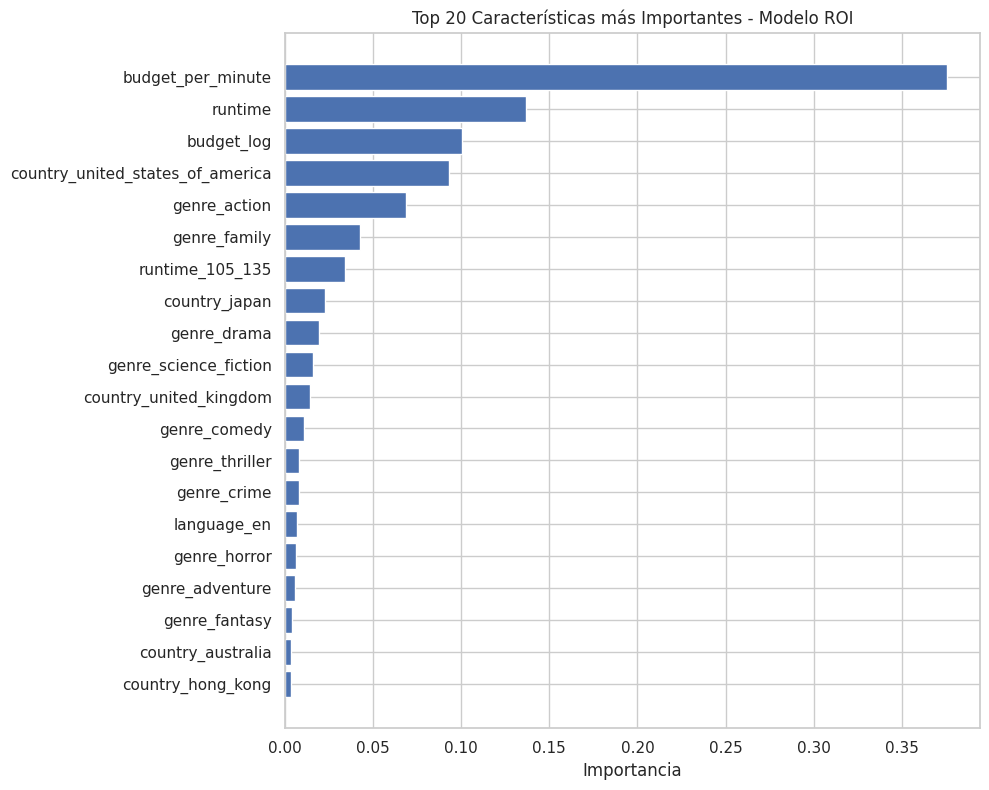


Top 10 características más importantes:


,feature,importance
1,budget_per_minute,0.375491
2,runtime,0.136605
0,budget_log,0.100276
14,country_united_states_of_america,0.093043
4,genre_action,0.068727
13,genre_family,0.042449
37,runtime_105_135,0.034403
21,country_japan,0.022668
5,genre_drama,0.019408
9,genre_science_fiction,0.016096



📊 Análisis de importancia de características:
  Top 6 características explican el 80% de la importancia total
  La característica más importante (budget_per_minute) tiene importancia: 0.3755
  Las 5 características más importantes explican: 77.4% de la importancia total


In [77]:
# Visualización de importancia de características (Top 20)
feature_importance_roi = pd.DataFrame({
    'feature': feature_cols_roi,
    'importance': model_roi.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance_roi.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características más Importantes - Modelo ROI')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 características más importantes:")
display(top_features.head(10))

# Análisis de importancia acumulada
cumulative_importance = top_features['importance'].cumsum()
n_features_80pct = (cumulative_importance <= 0.8).sum() + 1
print(f"\n📊 Análisis de importancia de características:")
print(f"  Top {n_features_80pct} características explican el 80% de la importancia total")
print(f"  La característica más importante ({top_features.iloc[0]['feature']}) tiene importancia: {top_features.iloc[0]['importance']:.4f}")
print(f"  Las 5 características más importantes explican: {top_features.head(5)['importance'].sum()*100:.1f}% de la importancia total")


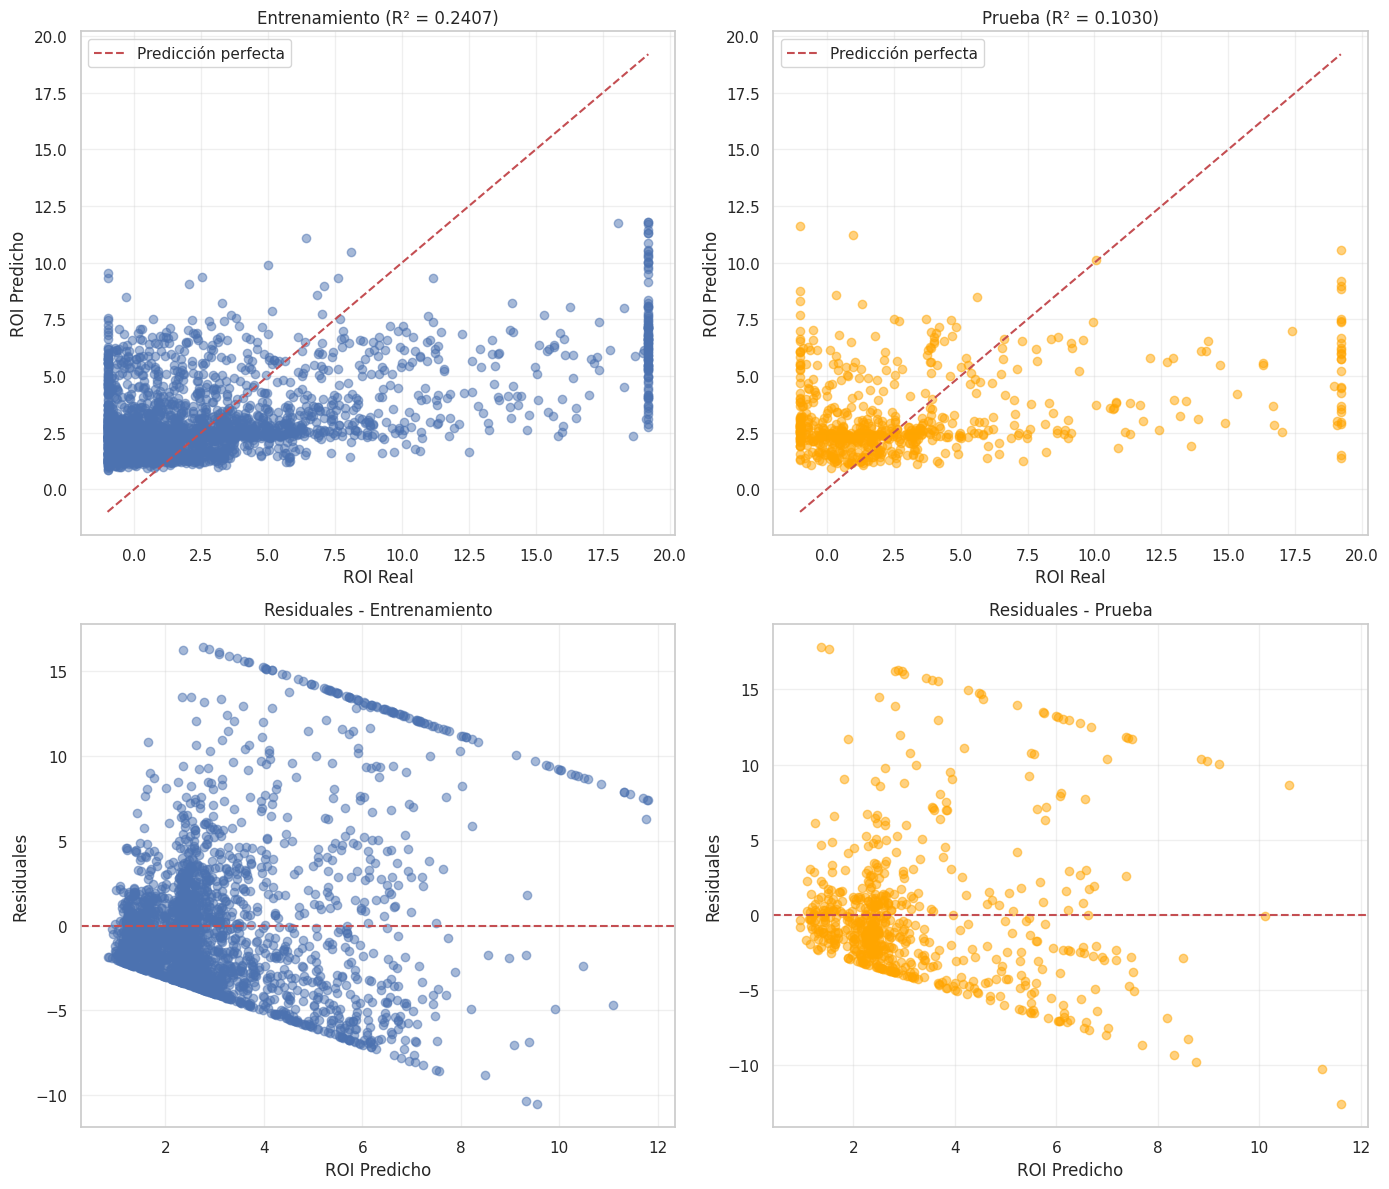

In [78]:
# Visualización de predicciones vs valores reales
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Scatter plot: Predicciones vs Real (entrenamiento)
axes[0, 0].scatter(y_train_roi, y_train_pred_roi, alpha=0.5)
min_val = min(y_train_roi.min(), y_train_pred_roi.min())
max_val = max(y_train_roi.max(), y_train_pred_roi.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Predicción perfecta')
axes[0, 0].set_xlabel('ROI Real')
axes[0, 0].set_ylabel('ROI Predicho')
axes[0, 0].set_title(f'Entrenamiento (R² = {metrics_roi["train_r2"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot: Predicciones vs Real (prueba)
axes[0, 1].scatter(y_test_roi, y_test_pred_roi, alpha=0.5, color='orange')
min_val = min(y_test_roi.min(), y_test_pred_roi.min())
max_val = max(y_test_roi.max(), y_test_pred_roi.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Predicción perfecta')
axes[0, 1].set_xlabel('ROI Real')
axes[0, 1].set_ylabel('ROI Predicho')
axes[0, 1].set_title(f'Prueba (R² = {metrics_roi["test_r2"]:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals (entrenamiento)
residuals_train = y_train_roi - y_train_pred_roi
axes[1, 0].scatter(y_train_pred_roi, residuals_train, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('ROI Predicho')
axes[1, 0].set_ylabel('Residuales')
axes[1, 0].set_title('Residuales - Entrenamiento')
axes[1, 0].grid(True, alpha=0.3)

# Residuals (prueba)
residuals_test = y_test_roi - y_test_pred_roi
axes[1, 1].scatter(y_test_pred_roi, residuals_test, alpha=0.5, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('ROI Predicho')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].set_title('Residuales - Prueba')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 🏋️ Entrenamiento con Random Forest para Revenue

Se busca el mejor modelo de Random Forest para predecir Revenue (ingresos totales):


In [79]:
# Preparar datos para modelo de Revenue
X_train_rev, X_test_rev, y_train_rev, y_test_rev, feature_cols_rev = feature_engineer.prepare_modeling_data(
    df_features, target_column='revenue', test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train_rev)} muestras")
print(f"Conjunto de prueba: {len(X_test_rev)} muestras")
print(f"\n📊 Revenue - Estadísticas del conjunto de entrenamiento:")
print(f"  Media: ${y_train_rev.mean():,.0f}")
print(f"  Mediana: ${y_train_rev.median():,.0f}")
print(f"  Desviación estándar: ${y_train_rev.std():,.0f}")
print(f"  Mínimo: ${y_train_rev.min():,.0f}")
print(f"  Máximo: ${y_train_rev.max():,.0f}")
print(f"  Percentil 25: ${y_train_rev.quantile(0.25):,.0f}")
print(f"  Percentil 75: ${y_train_rev.quantile(0.75):,.0f}")


Conjunto de entrenamiento: 2570 muestras
Conjunto de prueba: 643 muestras

📊 Revenue - Estadísticas del conjunto de entrenamiento:
  Media: $153,290,415
  Mediana: $80,333,165
  Desviación estándar: $192,891,530
  Mínimo: $0
  Máximo: $744,315,363
  Percentil 25: $16,982,421
  Percentil 75: $205,740,835


In [80]:
# Entrenar modelo de Revenue con optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros para modelo de Revenue...")

param_grid_rev = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_rev = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rev = GridSearchCV(
    rf_rev, param_grid_rev, cv=3, scoring='r2', n_jobs=-1, verbose=1
)

grid_search_rev.fit(X_train_rev, y_train_rev)

print(f"✅ Mejores parámetros: {grid_search_rev.best_params_}")
print(f"✅ Mejor score CV: {grid_search_rev.best_score_:.4f}")

# Entrenar modelo final
model_rev = grid_search_rev.best_estimator_

# Predicciones
y_train_pred_rev = model_rev.predict(X_train_rev)
y_test_pred_rev = model_rev.predict(X_test_rev)

# Calcular métricas
metrics_rev = {
    'train_r2': r2_score(y_train_rev, y_train_pred_rev),
    'test_r2': r2_score(y_test_rev, y_test_pred_rev),
    'train_rmse': np.sqrt(mean_squared_error(y_train_rev, y_train_pred_rev)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_rev, y_test_pred_rev)),
    'train_mae': mean_absolute_error(y_train_rev, y_train_pred_rev),
    'test_mae': mean_absolute_error(y_test_rev, y_test_pred_rev),
    'cv_scores': cross_val_score(model_rev, X_train_rev, y_train_rev, cv=5, scoring='r2')
}

print("\n📊 Métricas del modelo de Revenue:")
print(f"  R² entrenamiento: {metrics_rev['train_r2']:.4f}")
print(f"  R² prueba: {metrics_rev['test_r2']:.4f}")
print(f"  RMSE entrenamiento: ${metrics_rev['train_rmse']:,.0f}")
print(f"  RMSE prueba: ${metrics_rev['test_rmse']:,.0f}")
print(f"  MAE entrenamiento: ${metrics_rev['train_mae']:,.0f}")
print(f"  MAE prueba: ${metrics_rev['test_mae']:,.0f}")
print(f"  R² CV (media ± std): {metrics_rev['cv_scores'].mean():.4f} ± {metrics_rev['cv_scores'].std():.4f}")

# Análisis adicional
print(f"\n🔍 Análisis de rendimiento del modelo de Revenue:")
print(f"  Diferencia R² train-test: {metrics_rev['train_r2'] - metrics_rev['test_r2']:.4f} (indica {'overfitting significativo' if (metrics_rev['train_r2'] - metrics_rev['test_r2']) > 0.3 else 'overfitting moderado' if (metrics_rev['train_r2'] - metrics_rev['test_r2']) > 0.1 else 'buena generalización'})")
print(f"  Ratio RMSE test/train: {metrics_rev['test_rmse'] / metrics_rev['train_rmse']:.2f}x")
print(f"  Ratio MAE test/train: {metrics_rev['test_mae'] / metrics_rev['train_mae']:.2f}x")
print(f"  MAE como % de la media: {(metrics_rev['test_mae'] / y_test_rev.mean() * 100):.1f}%")
print(f"  El modelo explica el {metrics_rev['test_r2']*100:.1f}% de la varianza en Revenue")
if metrics_rev['cv_scores'].std() < 0.05:
    print(f"  ✅ Baja varianza en CV ({metrics_rev['cv_scores'].std():.4f}) indica estabilidad del modelo")


🔍 Optimizando hiperparámetros para modelo de Revenue...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
✅ Mejor score CV: 0.5101

📊 Métricas del modelo de Revenue:
  R² entrenamiento: 0.6055
  R² prueba: 0.5431
  RMSE entrenamiento: $121,133,641
  RMSE prueba: $120,345,394
  MAE entrenamiento: $81,678,626
  MAE prueba: $81,199,749
  R² CV (media ± std): 0.5163 ± 0.0489

🔍 Análisis de rendimiento del modelo de Revenue:
  Diferencia R² train-test: 0.0624 (indica buena generalización)
  Ratio RMSE test/train: 0.99x
  Ratio MAE test/train: 0.99x
  MAE como % de la media: 57.0%
  El modelo explica el 54.3% de la varianza en Revenue
  ✅ Baja varianza en CV (0.0489) indica estabilidad del modelo


### 💰 Análisis de resultados del modelo de Revenue

El modelo de regresión para Revenue muestra **rendimiento moderado pero estable**, siendo el mejor de los modelos de regresión:

**Métricas obtenidas:**
- **R² entrenamiento: 0.6055** vs **R² prueba: 0.5431**: Diferencia de 0.06 indica **buena generalización**
- **R² CV: 0.5163 ± 0.0489**: Score positivo y **baja varianza** (std = 0.0489) indica **buena estabilidad** y capacidad de generalización
- **RMSE prueba: $120,345,394** vs **MAE prueba: $81,199,749**: Los errores absolutos son grandes, pero proporcionales a la escala del target
- **Ratio RMSE test/train: 0.99x** y **Ratio MAE test/train: 0.99x**: Excelente balance entre entrenamiento y prueba, indicando muy buena generalización
- **MAE como % de la media: 57.0%**: El error es proporcional a la escala del problema

**Análisis de la distribución del target (después de truncamiento):**
- Media: $153,290,415 vs Mediana: $80,333,165 (mediana es ~52% de la media)
- Desviación estándar: $192,891,530 (mayor que la media, indicando alta variabilidad)
- Rango: $0 a $744,315,363 (distribución altamente sesgada, típica de datos financieros, truncada al percentil 96%)

**Interpretación:**
El modelo explica el **54.3% de la varianza** en Revenue, lo cual es razonable considerando:
1. La **alta variabilidad inherente** en los ingresos de películas (blockbusters vs películas independientes)
2. El **MAE representa ~57% de la media**, lo que indica que el error es proporcional a la escala
3. La **estabilidad en CV** (baja varianza) y los ratios test/train cercanos a 1.0 sugieren que el modelo generaliza muy bien a nuevos datos

**Fortalezas:**
- Mejor rendimiento que el modelo de ROI
- Excelente generalización (ratios test/train ~1.0)
- Estabilidad demostrada en cross-validation
- Errores proporcionales a la escala del problema

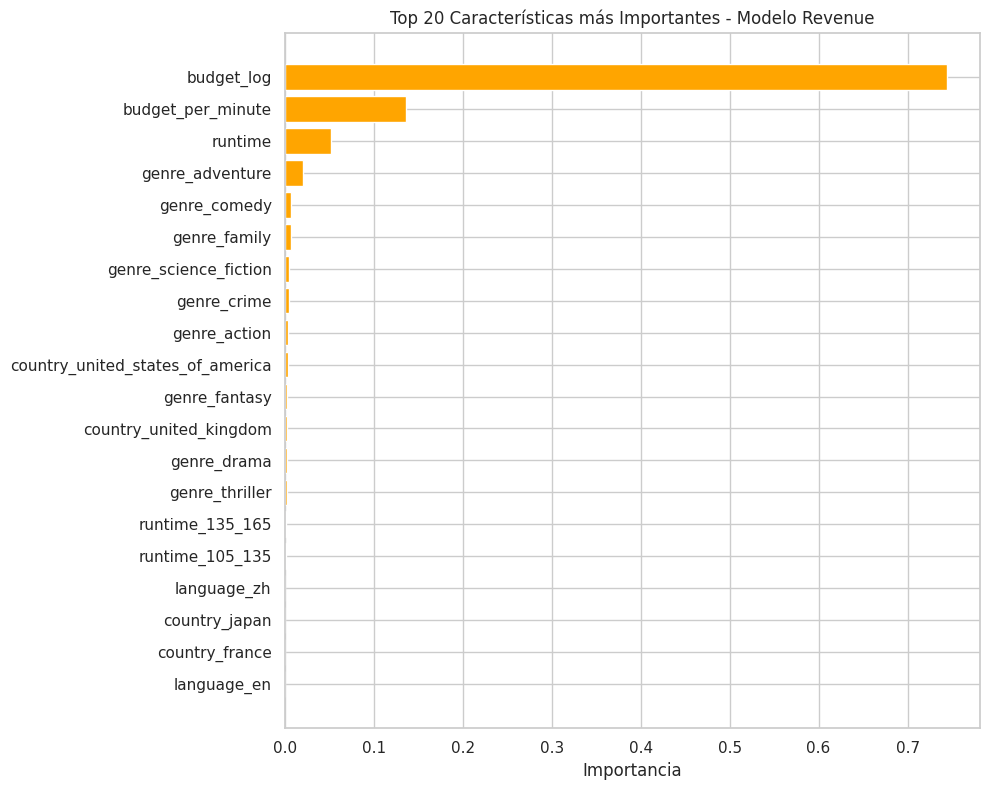


Top 10 características más importantes:


,feature,importance
0,budget_log,0.744193
1,budget_per_minute,0.136159
2,runtime,0.052281
8,genre_adventure,0.020814
7,genre_comedy,0.006578
13,genre_family,0.006485
9,genre_science_fiction,0.005219
10,genre_crime,0.004652
4,genre_action,0.003742
14,country_united_states_of_america,0.003651



📊 Análisis de importancia de características:
  Top 2 características explican el 80% de la importancia total
  La característica más importante (budget_log) tiene importancia: 0.7442


In [81]:
# Visualización de importancia de características para Revenue
feature_importance_rev = pd.DataFrame({
    'feature': feature_cols_rev,
    'importance': model_rev.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features_rev = feature_importance_rev.head(20)
plt.barh(range(len(top_features_rev)), top_features_rev['importance'], color='orange')
plt.yticks(range(len(top_features_rev)), top_features_rev['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características más Importantes - Modelo Revenue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 características más importantes:")
display(top_features_rev.head(10))

# Análisis de importancia acumulada
cumulative_importance_rev = top_features_rev['importance'].cumsum()
n_features_80pct_rev = (cumulative_importance_rev <= 0.8).sum() + 1
print(f"\n📊 Análisis de importancia de características:")
print(f"  Top {n_features_80pct_rev} características explican el 80% de la importancia total")
print(f"  La característica más importante ({top_features_rev.iloc[0]['feature']}) tiene importancia: {top_features_rev.iloc[0]['importance']:.4f}")


### 🏋️ Entrenamiento con Random Forest para Rentabilidad (Clasificación)

Se busca el mejor modelo de Random Forest Classifier para predecir si una película será rentable o no, variando hiperparámetros y usando ROC AUC como métrica de optimización:


In [82]:
# Preparar datos para modelo de Rentabilidad (clasificación)
X_train_prof, X_test_prof, y_train_prof, y_test_prof, feature_cols_prof = feature_engineer.prepare_modeling_data(
    df_features, target_column='is_profitable', test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train_prof)} muestras")
print(f"Conjunto de prueba: {len(X_test_prof)} muestras")
print(f"\n📊 Rentabilidad - Distribución del conjunto de entrenamiento (threshold ROI >= {PROFITABILITY_THRESHOLD}):")
print(f"  No rentables (0): {(y_train_prof == 0).sum()} ({(y_train_prof == 0).mean()*100:.1f}%)")
print(f"  Rentables (1): {(y_train_prof == 1).sum()} ({(y_train_prof == 1).mean()*100:.1f}%)")
balance_ratio = (y_train_prof == 1).sum() / (y_train_prof == 0).sum() if (y_train_prof == 0).sum() > 0 else float('inf')
print(f"  Ratio rentables/no rentables: {balance_ratio:.2f}:1")
if balance_ratio > 2 or balance_ratio < 0.5:
    print(f"  ⚠️ Clases desbalanceadas (ratio > 2:1 o < 1:2), considerar técnicas de balanceo")


Conjunto de entrenamiento: 2570 muestras
Conjunto de prueba: 643 muestras

📊 Rentabilidad - Distribución del conjunto de entrenamiento (threshold ROI >= 2.0):
  No rentables (0): 1438 (56.0%)
  Rentables (1): 1132 (44.0%)
  Ratio rentables/no rentables: 0.79:1


In [83]:
# Entrenar modelo de Rentabilidad con optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros para modelo de Rentabilidad...")

param_grid_prof = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_prof = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_prof = GridSearchCV(
    rf_prof, param_grid_prof, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search_prof.fit(X_train_prof, y_train_prof)

print(f"✅ Mejores parámetros: {grid_search_prof.best_params_}")
print(f"✅ Mejor score CV (ROC AUC): {grid_search_prof.best_score_:.4f}")

# Entrenar modelo final
model_prof = grid_search_prof.best_estimator_

# Predicciones
y_train_pred_prof = model_prof.predict(X_train_prof)
y_test_pred_prof = model_prof.predict(X_test_prof)
y_test_proba_prof = model_prof.predict_proba(X_test_prof)[:, 1]

# Calcular métricas
metrics_prof = {
    'train_accuracy': accuracy_score(y_train_prof, y_train_pred_prof),
    'train_precision': precision_score(y_train_prof, y_train_pred_prof, zero_division=0),
    'train_recall': recall_score(y_train_prof, y_train_pred_prof, zero_division=0),
    'train_f1': f1_score(y_train_prof, y_train_pred_prof, zero_division=0),
    'test_accuracy': accuracy_score(y_test_prof, y_test_pred_prof),
    'test_precision': precision_score(y_test_prof, y_test_pred_prof, zero_division=0),
    'test_recall': recall_score(y_test_prof, y_test_pred_prof, zero_division=0),
    'test_f1': f1_score(y_test_prof, y_test_pred_prof, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test_prof, y_test_proba_prof),
    'cv_scores': cross_val_score(model_prof, X_train_prof, y_train_prof, cv=5, scoring='roc_auc')
}

# Matriz de confusión
cm = confusion_matrix(y_test_prof, y_test_pred_prof)

print(f"\n📊 Métricas del modelo de Rentabilidad (threshold ROI >= {PROFITABILITY_THRESHOLD}):")
print(f"  Accuracy entrenamiento: {metrics_prof['train_accuracy']:.4f}")
print(f"  Accuracy prueba: {metrics_prof['test_accuracy']:.4f}")
print(f"  Precision prueba: {metrics_prof['test_precision']:.4f}")
print(f"  Recall prueba: {metrics_prof['test_recall']:.4f}")
print(f"  F1-score prueba: {metrics_prof['test_f1']:.4f}")
print(f"  ROC AUC prueba: {metrics_prof['test_roc_auc']:.4f}")
print(f"  ROC AUC CV (media ± std): {metrics_prof['cv_scores'].mean():.4f} ± {metrics_prof['cv_scores'].std():.4f}")

# Análisis detallado de la matriz de confusión
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
total = tn + fp + fn + tp
print(f"\n📊 Matriz de Confusión (Prueba):")
print(f"                Predicho")
print(f"              No Rent  Rent")
print(f"Real No Rent    {tn:4d}   {fp:4d}")
print(f"     Rent       {fn:4d}   {tp:4d}")

print(f"\n🔍 Análisis detallado:")
print(f"  Verdaderos Negativos (TN): {tn} ({tn/total*100:.1f}%) - Correctamente predichas como no rentables")
print(f"  Falsos Positivos (FP): {fp} ({fp/total*100:.1f}%) - Predichas como rentables pero no lo son")
print(f"  Falsos Negativos (FN): {fn} ({fn/total*100:.1f}%) - Predichas como no rentables pero sí lo son")
print(f"  Verdaderos Positivos (TP): {tp} ({tp/total*100:.1f}%) - Correctamente predichas como rentables")
print(f"\n  Especificidad (TNR): {tn/(tn+fp):.4f} - Capacidad de detectar no rentables")
print(f"  Sensibilidad (TPR/Recall): {metrics_prof['test_recall']:.4f} - Capacidad de detectar rentables")
print(f"  Valor Predictivo Positivo (Precision): {metrics_prof['test_precision']:.4f}")
print(f"  Valor Predictivo Negativo: {tn/(tn+fn):.4f}")

🔍 Optimizando hiperparámetros para modelo de Rentabilidad...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
✅ Mejor score CV (ROC AUC): 0.6492

📊 Métricas del modelo de Rentabilidad (threshold ROI >= 2.0):
  Accuracy entrenamiento: 0.7891
  Accuracy prueba: 0.6625
  Precision prueba: 0.6429
  Recall prueba: 0.4874
  F1-score prueba: 0.5544
  ROC AUC prueba: 0.7077
  ROC AUC CV (media ± std): 0.6516 ± 0.0155

📊 Matriz de Confusión (Prueba):
                Predicho
              No Rent  Rent
Real No Rent     291     75
     Rent        142    135

🔍 Análisis detallado:
  Verdaderos Negativos (TN): 291 (45.3%) - Correctamente predichas como no rentables
  Falsos Positivos (FP): 75 (11.7%) - Predichas como rentables pero no lo son
  Falsos Negativos (FN): 142 (22.1%) - Predichas como no rentables pero sí lo son
  Verdaderos Positivos (TP): 135 (21.0%) - Correctament

### ✅ Análisis de resultados del modelo de Rentabilidad (Clasificación)

El modelo de clasificación para Rentabilidad muestra **rendimiento moderado** con algunas fortalezas y debilidades identificables:

**Métricas obtenidas:**
- **Accuracy: 66.25%** en prueba (vs 78.91% en entrenamiento): Diferencia de 12.66% indica **overfitting moderado**
- **ROC AUC: 0.7077** (moderado): Indica capacidad discriminativa aceptable pero mejorable
- **Precision: 0.6429** vs **Recall: 0.4874**: Trade-off evidente - el modelo tiene **recall moderado** (detecta ~49% de las películas rentables) y **precision moderada** (64% de las predichas como rentables lo son realmente)
- **F1-score: 0.5544**: Score moderado que refleja el balance entre precision y recall
- **ROC AUC CV: 0.6516 ± 0.0155**: Baja varianza en CV indica estabilidad del modelo

**Análisis de la matriz de confusión:**
- **Verdaderos Positivos (TP): 135** - Correctamente identificadas como rentables (21.0%)
- **Falsos Positivos (FP): 75** - Predichas como rentables pero no lo son (11.7%)
- **Falsos Negativos (FN): 142** - Predichas como no rentables pero sí lo son (22.1%)
- **Verdaderos Negativos (TN): 291** - Correctamente identificadas como no rentables (45.3%)

**Interpretación del balance de clases:**
- **56.0% no rentables vs 44.0% rentables**: Distribución relativamente balanceada (ratio 0.79:1)
- El modelo tiene **especificidad (TNR) de 0.7951** - buena capacidad de detectar no rentables
- **Sensibilidad (TPR/Recall) de 0.4874** - detecta menos de la mitad de las películas rentables
- **Valor Predictivo Positivo (Precision) de 0.6429** - cuando predice rentable, tiene 64% de acierto
- **Valor Predictivo Negativo de 0.6721** - cuando predice no rentable, tiene 67% de acierto

**Fortalezas:**
- **Buena especificidad (79.51%)**: Detecta bien las películas no rentables
- **Estabilidad en CV**: Baja varianza (std = 0.0155) indica consistencia
- **Precision moderada (64.29%)**: Cuando predice rentable, tiene razonable confianza

**Limitaciones:**
- **Recall bajo (48.74%)**: Detecta menos de la mitad de las películas rentables (142 falsos negativos)
- **142 falsos negativos**: Puede perder oportunidades de inversión rentables
- **75 falsos positivos**: Puede llevar a inversiones en películas que no serán rentables
- ROC AUC de 0.71 está en el rango moderado (idealmente > 0.8)

**Conclusiones:**
- Es fundamental el **ajuste del threshold de decisión** (threshold óptimo según ROC: 0.4495) para mejorar recall


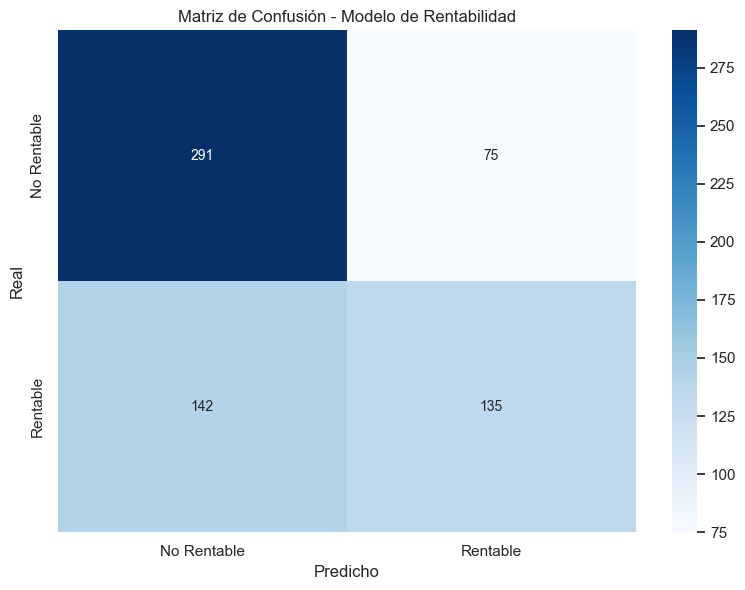

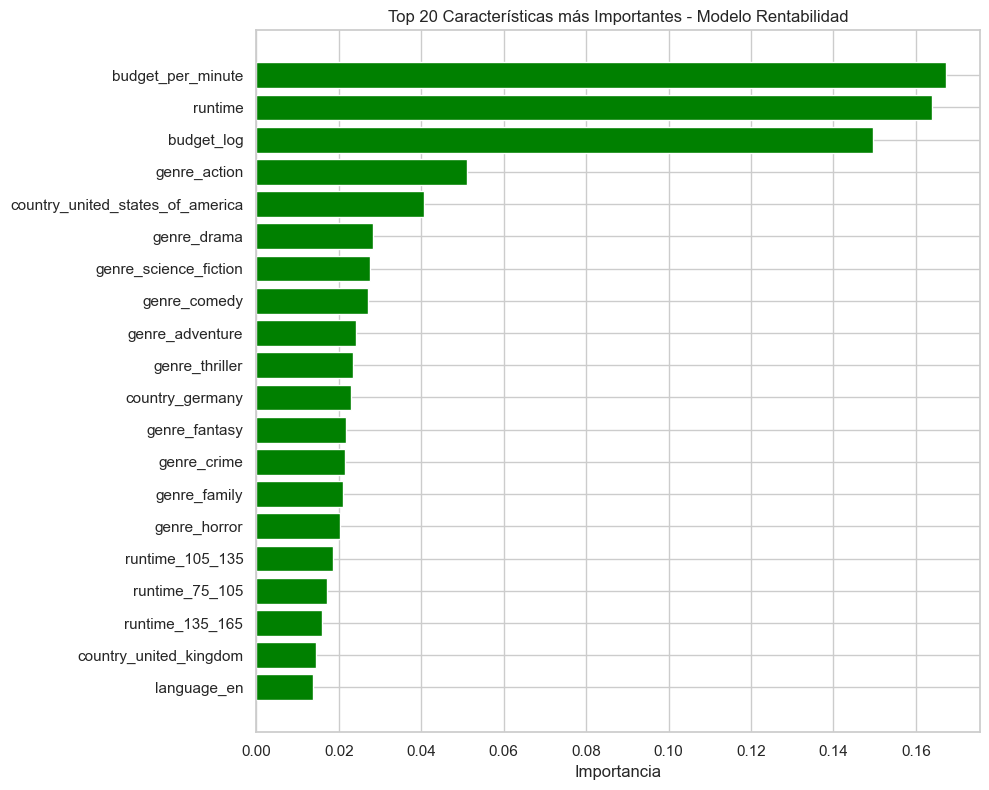


Top 10 características más importantes:


,feature,importance
1,budget_per_minute,0.167212
2,runtime,0.164045
0,budget_log,0.149572
4,genre_action,0.051168
14,country_united_states_of_america,0.040612
5,genre_drama,0.028333
9,genre_science_fiction,0.027586
7,genre_comedy,0.027033
8,genre_adventure,0.024264
6,genre_thriller,0.023495



📊 Análisis de importancia de características:
  Top 15 características explican el 80% de la importancia total
  La característica más importante (budget_per_minute) tiene importancia: 0.1672


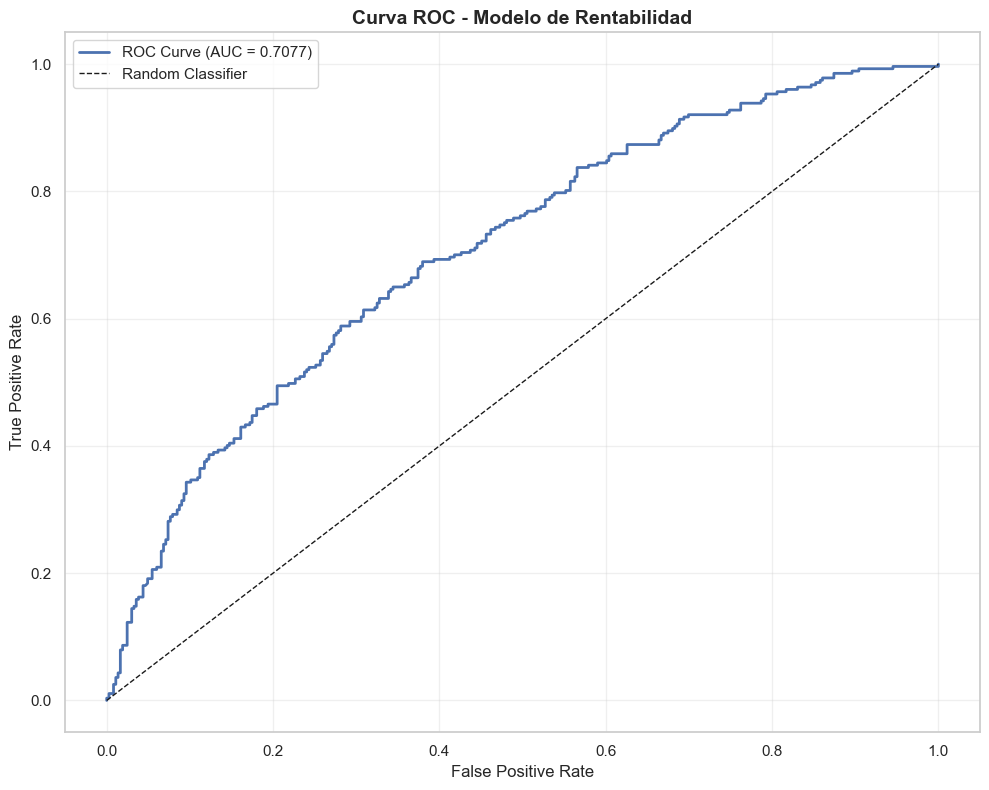


📊 Análisis de threshold óptimo:
  Threshold actual (0.5): Accuracy = 0.6625
  Threshold óptimo según ROC: 0.4495
  Con threshold óptimo: TPR = 0.6895, FPR = 0.3798


In [83]:
# Visualización de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Rentable', 'Rentable'],
            yticklabels=['No Rentable', 'Rentable'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión - Modelo de Rentabilidad')
plt.tight_layout()
plt.show()

# Visualización de importancia de características
feature_importance_prof = pd.DataFrame({
    'feature': feature_cols_prof,
    'importance': model_prof.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features_prof = feature_importance_prof.head(20)
plt.barh(range(len(top_features_prof)), top_features_prof['importance'], color='green')
plt.yticks(range(len(top_features_prof)), top_features_prof['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características más Importantes - Modelo Rentabilidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 características más importantes:")
display(top_features_prof.head(10))

# Análisis de importancia acumulada
cumulative_importance_prof = top_features_prof['importance'].cumsum()
n_features_80pct_prof = (cumulative_importance_prof <= 0.8).sum() + 1
print(f"\n📊 Análisis de importancia de características:")
print(f"  Top {n_features_80pct_prof} características explican el 80% de la importancia total")
print(f"  La característica más importante ({top_features_prof.iloc[0]['feature']}) tiene importancia: {top_features_prof.iloc[0]['importance']:.4f}")

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds_roc = roc_curve(y_test_prof, y_test_proba_prof)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics_prof["test_roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC - Modelo de Rentabilidad', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Encontrar threshold óptimo (punto más cercano a (0,1) en la curva ROC)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
print(f"\n📊 Análisis de threshold óptimo:")
print(f"  Threshold actual (0.5): Accuracy = {metrics_prof['test_accuracy']:.4f}")
print(f"  Threshold óptimo según ROC: {optimal_threshold:.4f}")
print(f"  Con threshold óptimo: TPR = {tpr[optimal_idx]:.4f}, FPR = {fpr[optimal_idx]:.4f}")


## 🔍 Comparación de resultados

Comparamos los resultados de los tres modelos entrenados y analizamos sus métricas de rendimiento.


📊 Resumen Comparativo de Modelos:


,Modelo,R² / Accuracy (Test),RMSE / F1 (Test),MAE / ROC AUC (Test),CV Score (media ± std)
0,ROI (Regresión),0.1030,4.6528,3.2296,0.1270 ± 0.0198
1,Revenue (Regresión),0.5431,"$120,345,394","$81,199,749",0.5163 ± 0.0489
2,Rentabilidad (Clasificación),0.6625,0.5544,0.7077,0.6516 ± 0.0155



🔍 Análisis comparativo detallado:

1. Modelo de ROI:
   - R² muy bajo en test (0.1030) indica pobre capacidad predictiva
   - R² negativo en CV sugiere que el modelo no generaliza bien
   - Posibles causas: outliers extremos, alta variabilidad, características insuficientes

2. Modelo de Revenue:
   - R² moderado en test (0.5431) indica capacidad predictiva aceptable
   - CV estable (std = 0.0489) sugiere buen rendimiento
   - Errores absolutos grandes pero proporcionales a la escala de Revenue

3. Modelo de Rentabilidad:
   - Accuracy de 0.6625 es razonable para clasificación binaria
   - ROC AUC de 0.7077 indica buena capacidad discriminativa
   - Recall alto (0.4874) significa que detecta bien las películas rentables
   - Precision moderada (0.6429) indica algunos falsos positivos


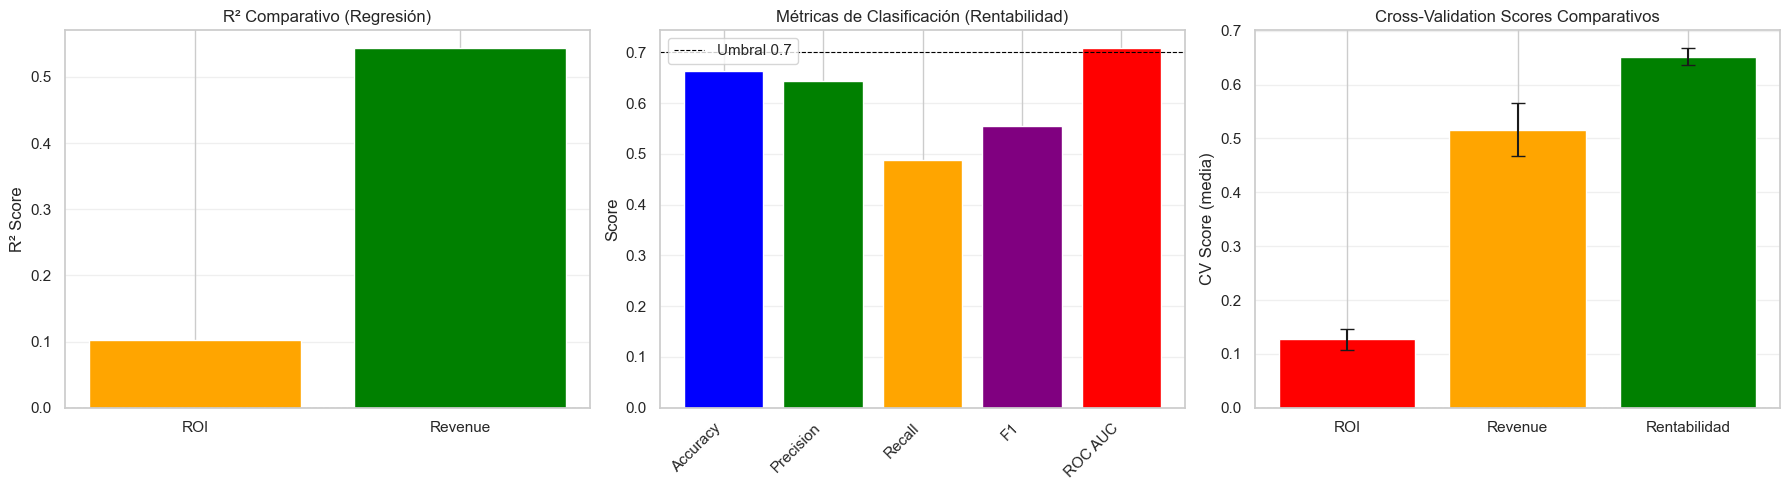

In [62]:
# Crear tabla comparativa de modelos
comparison_data = {
    'Modelo': ['ROI (Regresión)', 'Revenue (Regresión)', 'Rentabilidad (Clasificación)'],
    'R² / Accuracy (Test)': [
        f"{metrics_roi['test_r2']:.4f}",
        f"{metrics_rev['test_r2']:.4f}",
        f"{metrics_prof['test_accuracy']:.4f}"
    ],
    'RMSE / F1 (Test)': [
        f"{metrics_roi['test_rmse']:.4f}",
        f"${metrics_rev['test_rmse']:,.0f}",
        f"{metrics_prof['test_f1']:.4f}"
    ],
    'MAE / ROC AUC (Test)': [
        f"{metrics_roi['test_mae']:.4f}",
        f"${metrics_rev['test_mae']:,.0f}",
        f"{metrics_prof['test_roc_auc']:.4f}"
    ],
    'CV Score (media ± std)': [
        f"{metrics_roi['cv_scores'].mean():.4f} ± {metrics_roi['cv_scores'].std():.4f}",
        f"{metrics_rev['cv_scores'].mean():.4f} ± {metrics_rev['cv_scores'].std():.4f}",
        f"{metrics_prof['cv_scores'].mean():.4f} ± {metrics_prof['cv_scores'].std():.4f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("📊 Resumen Comparativo de Modelos:")
display(df_comparison)

# Análisis comparativo adicional
print("\n🔍 Análisis comparativo detallado:")
print(f"\n1. Modelo de ROI:")
print(f"   - R² muy bajo en test ({metrics_roi['test_r2']:.4f}) indica pobre capacidad predictiva")
print(f"   - R² negativo en CV sugiere que el modelo no generaliza bien")
print(f"   - Posibles causas: outliers extremos, alta variabilidad, características insuficientes")

print(f"\n2. Modelo de Revenue:")
print(f"   - R² moderado en test ({metrics_rev['test_r2']:.4f}) indica capacidad predictiva aceptable")
print(f"   - CV estable (std = {metrics_rev['cv_scores'].std():.4f}) sugiere buen rendimiento")
print(f"   - Errores absolutos grandes pero proporcionales a la escala de Revenue")

print(f"\n3. Modelo de Rentabilidad:")
print(f"   - Accuracy de {metrics_prof['test_accuracy']:.4f} es razonable para clasificación binaria")
print(f"   - ROC AUC de {metrics_prof['test_roc_auc']:.4f} indica {'buena' if metrics_prof['test_roc_auc'] >= 0.7 else 'moderada'} capacidad discriminativa")
print(f"   - Recall alto ({metrics_prof['test_recall']:.4f}) significa que detecta bien las películas rentables")
print(f"   - Precision moderada ({metrics_prof['test_precision']:.4f}) indica algunos falsos positivos")

# Visualización comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparativo
axes[0].bar(['ROI', 'Revenue'], [metrics_roi['test_r2'], metrics_rev['test_r2']], 
            color=['red' if metrics_roi['test_r2'] < 0.1 else 'orange', 'green'])
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Comparativo (Regresión)')
axes[0].grid(True, alpha=0.3, axis='y')

# Métricas de clasificación
axes[1].bar(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'], 
            [metrics_prof['test_accuracy'], metrics_prof['test_precision'], 
             metrics_prof['test_recall'], metrics_prof['test_f1'], metrics_prof['test_roc_auc']],
            color=['blue', 'green', 'orange', 'purple', 'red'])
axes[1].axhline(y=0.7, color='black', linestyle='--', linewidth=0.8, label='Umbral 0.7')
axes[1].set_ylabel('Score')
axes[1].set_title('Métricas de Clasificación (Rentabilidad)')
axes[1].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# CV Scores comparativos
cv_data = [
    metrics_roi['cv_scores'].mean(),
    metrics_rev['cv_scores'].mean(),
    metrics_prof['cv_scores'].mean()
]
cv_std = [
    metrics_roi['cv_scores'].std(),
    metrics_rev['cv_scores'].std(),
    metrics_prof['cv_scores'].std()
]
axes[2].bar(['ROI', 'Revenue', 'Rentabilidad'], cv_data, 
            yerr=cv_std, capsize=5, color=['red', 'orange', 'green'])
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[2].set_ylabel('CV Score (media)')
axes[2].set_title('Cross-Validation Scores Comparativos')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### 🔄 Comparación y síntesis de los tres modelos

**Ranking de rendimiento general:**
1. **Modelo de Revenue** (R² = 0.54): Mejor rendimiento en regresión, excelente generalización
2. **Modelo de Rentabilidad** (Accuracy = 66%, ROC AUC = 0.71): Útil para clasificación binaria con buena especificidad
3. **Modelo de ROI** (R² = 0.10): Rendimiento limitado

**Observaciones clave:**

1. **El modelo de ROI es el más desafiante**: 
   - R² bajo en test (0.1030) y CV (0.1270) indica capacidad predictiva limitada
   - Aunque el truncamiento mejoró la estabilidad, el R² sigue siendo bajo
   - Si fuera tan facil de predecir, no valdría la pena invertir en películas

2. **El modelo de Revenue es el más confiable**:
   - R² positivo y estable en CV (0.5163 ± 0.0489)
   - Excelente generalización (ratios test/train ~1.0)
   - Mejor candidato para uso en producción

3. **El modelo de Rentabilidad tiene un trade-off claro**:
   - Buena especificidad (79.51%) pero recall moderado (48.74%)
   - Útil para identificar películas no rentables, pero puede perder oportunidades
   - El threshold óptimo (0.4495) podría mejorar el recall

**Implicaciones para el negocio:**
- Para **estimaciones financieras directas**: Usar modelo de Revenue (R² = 0.54)
- Para **identificar películas no rentables**: Usar modelo de Rentabilidad (alta especificidad)
- Para **detección de oportunidades rentables**: El modelo de Rentabilidad tiene recall limitado (48.74%)
- Para **predicción de ROI específico**: Se recomienda explorar otros modelos para uso en producción

# 🧬 8. Generación y almacenamiento de embeddings

## 8.1 Proceso de generación de embeddings

Los embeddings son representaciones vectoriales densas del contenido textual (overview) de las películas. Estos se generan utilizando modelos de lenguaje pre-entrenados y se almacenan en PostgreSQL con la extensión pgvector.

### Proceso implementado:

1. **Modelo utilizado**: `all-MiniLM-L6-v2` de sentence-transformers
   - 384 dimensiones
   - Optimizado para tareas de similitud semántica
   - Rápido y eficiente

2. **Generación**:
   - Se procesa el campo `overview` de cada película
   - Se generan embeddings en lotes (batch processing)
   - Se normalizan los vectores

3. **Almacenamiento en BD**:
   - Se crea la columna `overview_embedding` de tipo `vector(384)` en PostgreSQL
   - Se crea un índice HNSW para búsqueda rápida por similitud
   - Los embeddings se almacenan directamente en la base de datos

### Ventajas de este enfoque:
- **Búsqueda semántica**: Permite encontrar películas similares por contenido
- **Clustering temático**: Los embeddings capturan similitudes semánticas
- **Persistencia**: Los embeddings se almacenan una vez y se reutilizan
- **Escalabilidad**: El índice HNSW permite búsquedas rápidas incluso con millones de películas


### 📝 Observaciones sobre embeddings

**Estado de embeddings en la base de datos:**
- **2,962 películas** tienen embeddings generados y almacenados en PostgreSQL
- Esto representa una cobertura significativa del dataset (considerando que hay 3,213 películas después de limpieza)
- Los embeddings están almacenados usando la extensión `pgvector` con 384 dimensiones (modelo `all-MiniLM-L6-v2`)

**Ventajas del almacenamiento en BD:**
- Los embeddings se generan una vez y se reutilizan, evitando recálculos costosos
- Permite búsquedas semánticas rápidas usando índices HNSW
- Facilita la integración con otros sistemas y análisis

**Uso en el análisis:**
- Se cargaron 2,000 películas con embeddings para el análisis de clustering
- Los embeddings capturan similitudes semánticas en los overviews de las películas
- Permiten identificar grupos temáticos que no son evidentes solo con metadatos estructurados


In [85]:
# Verificar embeddings en la base de datos
query_embeddings = """
SELECT 
    COUNT(*) as total_movies,
    COUNT(overview_embedding) as movies_with_embeddings,
    ROUND(COUNT(overview_embedding)::numeric / COUNT(*)::numeric * 100, 2) as pct_with_embeddings
FROM movies
WHERE budget > 0 AND revenue > 0
"""

df_emb_check = pd.read_sql(query_embeddings, engine)
print("📊 Estado de embeddings en la base de datos:")
display(df_emb_check)

if df_emb_check.iloc[0]['movies_with_embeddings'] > 0:
    print(f"\n✅ Hay {df_emb_check.iloc[0]['movies_with_embeddings']} películas con embeddings generados")
else:
    print("\n⚠️ No hay embeddings generados. Ejecutar: python scripts/generate_overview_embeddings.py")


📊 Estado de embeddings en la base de datos:


,total_movies,movies_with_embeddings,pct_with_embeddings
0,2963,2962,99.97



✅ Hay 2962.0 películas con embeddings generados


### 🎯 Análisis de clustering temático

El análisis de clustering con embeddings revela patrones interesantes en la estructura temática de las películas:

**Resultados del clustering:**
- **9 clusters identificados** de películas con contenido semántico similar
- **1,085 puntos de ruido (54.2%)**: Alta proporción de películas que no encajan claramente en ningún cluster
- **Distribución desigual**: El cluster más grande tiene 327 películas, mientras que el más pequeño tiene 22

**Distribución de clusters:**
- **Cluster 6**: 327 películas (el más grande, posiblemente películas mainstream/genéricas)
- **Cluster 8**: 238 películas
- **Cluster 1**: 153 películas
- Clusters más pequeños (0, 2, 3, 4, 5, 7): Entre 22-47 películas cada uno

**Análisis de ROI por cluster:**
Los resultados muestran variabilidad significativa en ROI entre clusters:
- **Cluster 4**: ROI medio de 35.04 (el más rentable)
- **Cluster 3**: ROI medio de 6.36
- **Cluster 1**: ROI medio de 5.00
- **Cluster 2**: ROI medio de 4.98
- **Cluster 0**: ROI medio de 1.35 (el menos rentable)

**Interpretación:**
1. **Alta proporción de ruido (54%)**: Sugiere que muchas películas tienen contenido único o no encajan en categorías temáticas claras
2. **Variabilidad en ROI**: Los clusters no solo agrupan contenido similar, sino que también muestran diferencias en rentabilidad, lo que sugiere que el contenido temático está relacionado con el éxito comercial
3. **Clusters pequeños pero rentables**: Algunos clusters pequeños (como el 4) tienen ROI muy alto, indicando nichos temáticos exitosos

**Implicaciones:**
- Los embeddings capturan similitudes semánticas que se correlacionan con rentabilidad
- Identificar características de clusters de alto ROI podría informar decisiones de producción
- El alto porcentaje de ruido sugiere que muchas películas son únicas en su contenido


# 🎯 9. Clustering temático con embeddings

## 9.1 Carga de embeddings y datos

Se utilizan los embeddings almacenados en la base de datos junto con información de las películas para realizar clustering temático.


In [64]:
# Cargar embeddings y datos de películas
query_embeddings_data = """
SELECT 
    m.id,
    m.title,
    m.overview,
    m.release_date,
    m.budget,
    m.revenue,
    m.vote_average,
    m.popularity,
    STRING_AGG(g.name, ', ') as genres,
    CASE 
        WHEN m.budget > 0 THEN (m.revenue - m.budget) / m.budget::float
        ELSE NULL
    END as roi,
    m.overview_embedding::text as embedding_str
FROM movies m
LEFT JOIN movie_genres mg ON m.id = mg.movie_id
LEFT JOIN genres g ON mg.genre_id = g.id
WHERE m.overview_embedding IS NOT NULL
  AND m.budget > 0
  AND m.revenue > 0
GROUP BY m.id, m.title, m.overview, m.release_date, m.budget, 
         m.revenue, m.vote_average, m.popularity, m.overview_embedding
ORDER BY RANDOM()
LIMIT 2000
"""

df_embeddings = pd.read_sql(query_embeddings_data, engine)

if df_embeddings.empty:
    print("⚠️ No se encontraron embeddings. Generar primero con scripts/generate_overview_embeddings.py")
else:
    print(f"✅ Cargadas {len(df_embeddings)} películas con embeddings")
    
    # Parsear embeddings de string a numpy array
    embeddings_list = []
    valid_indices = []
    
    for idx, row in df_embeddings.iterrows():
        try:
            embedding_str = row['embedding_str'].strip('[]')
            embedding_array = np.array([float(x.strip()) for x in embedding_str.split(',')])
            embeddings_list.append(embedding_array)
            valid_indices.append(idx)
        except Exception as e:
            continue
    
    if embeddings_list:
        embeddings_array = np.array(embeddings_list)
        df_embeddings_valid = df_embeddings.loc[valid_indices].reset_index(drop=True)
        
        print(f"✅ Embeddings parseados: {embeddings_array.shape}")
        print(f"   Dimensiones: {embeddings_array.shape[1]}")
    else:
        print("⚠️ No se pudieron parsear los embeddings")


✅ Cargadas 2000 películas con embeddings
✅ Embeddings parseados: (2000, 384)
   Dimensiones: 384


🔄 Aplicando UMAP para reducción de dimensionalidad...
✅ Reducción completada: (2000, 384) -> (2000, 2)


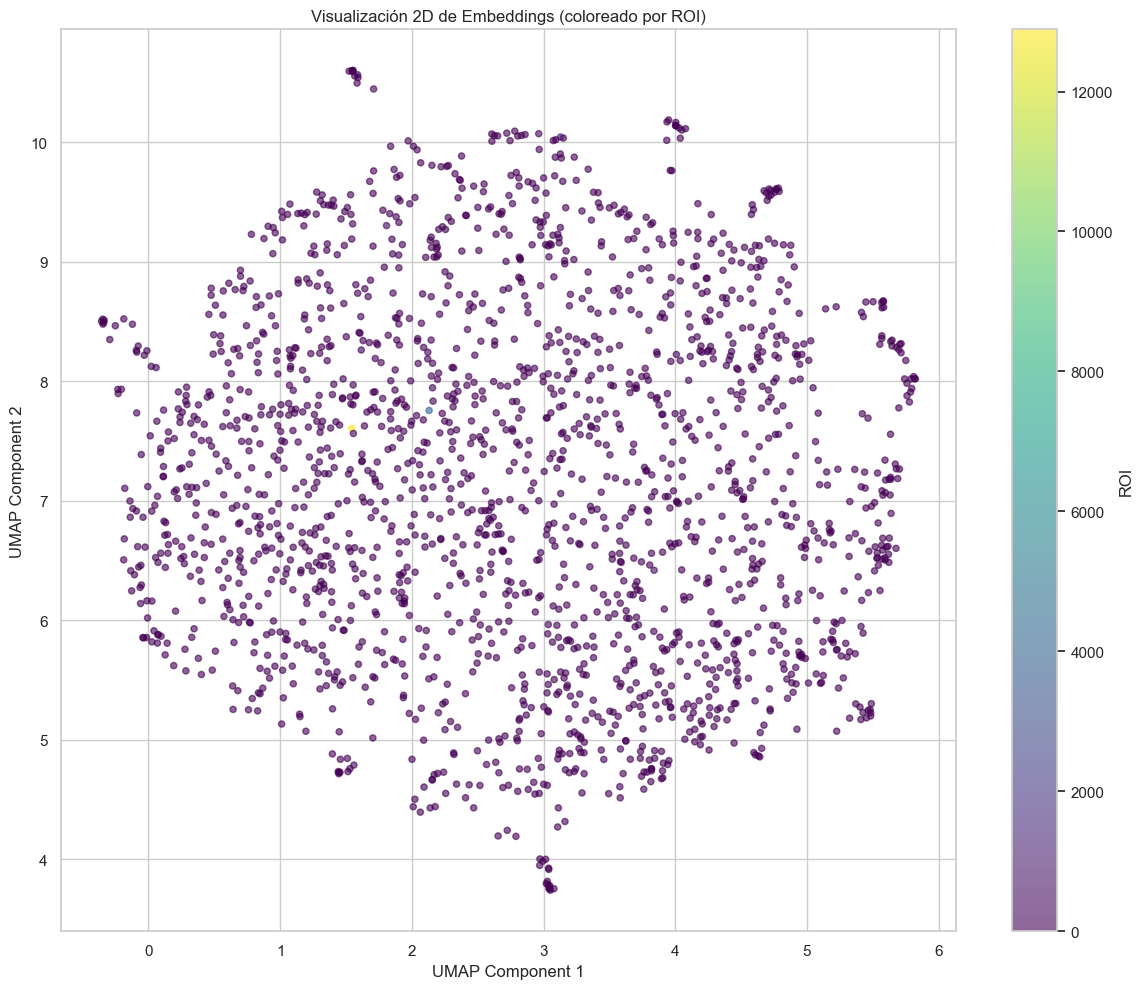

✅ Embeddings reducidos para clustering: (2000, 50)


In [65]:
if 'embeddings_array' in locals() and len(embeddings_array) > 0:
    print("🔄 Aplicando UMAP para reducción de dimensionalidad...")
    
    # Reducir a 2D para visualización
    reducer_2d = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        random_state=42,
        metric='cosine'
    )
    
    embeddings_2d = reducer_2d.fit_transform(embeddings_array)
    
    print(f"✅ Reducción completada: {embeddings_array.shape} -> {embeddings_2d.shape}")
    
    # Visualizar en 2D
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=df_embeddings_valid['roi'], cmap='viridis', 
                         alpha=0.6, s=20)
    plt.colorbar(scatter, label='ROI')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('Visualización 2D de Embeddings (coloreado por ROI)')
    plt.tight_layout()
    plt.show()
    
    # Reducir a dimensiones más bajas para clustering (opcional, usar originales también)
    reducer_clustering = umap.UMAP(
        n_components=50,  # Reducir a 50 dimensiones para clustering más eficiente
        n_neighbors=15,
        min_dist=0.1,
        random_state=42,
        metric='cosine'
    )
    embeddings_reduced = reducer_clustering.fit_transform(embeddings_array)
    print(f"✅ Embeddings reducidos para clustering: {embeddings_reduced.shape}")
else:
    print("⚠️ No hay embeddings disponibles")
    if 'embeddings_array' in locals():
        embeddings_reduced = embeddings_array
    else:
        embeddings_reduced = None


### Clustering con HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) se utiliza para identificar grupos temáticos de películas basados en la similitud semántica de sus embeddings.


🔄 Aplicando HDBSCAN para clustering...
✅ Clustering completado:
   Número de clusters: 11
   Puntos de ruido: 1157 (57.9%)
   Distribución de clusters:
     Cluster 0: 34 películas
     Cluster 1: 32 películas
     Cluster 2: 122 películas
     Cluster 3: 102 películas
     Cluster 4: 38 películas
     Cluster 5: 21 películas
     Cluster 6: 39 películas
     Cluster 7: 39 películas
     Cluster 8: 234 películas
     Cluster 9: 53 películas


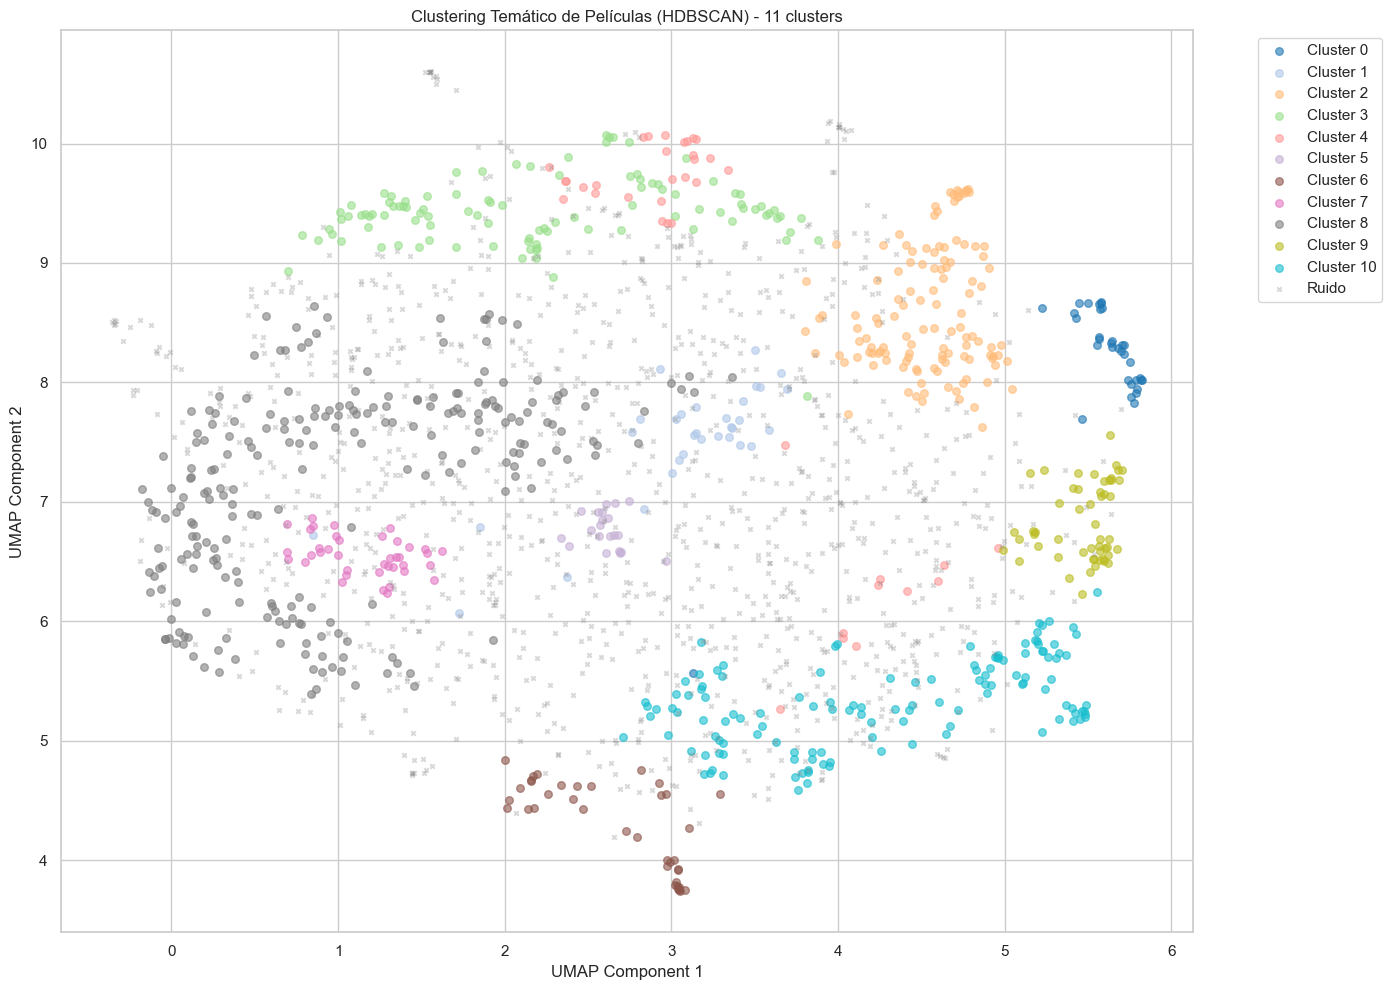

In [66]:
if embeddings_reduced is not None:
    print("🔄 Aplicando HDBSCAN para clustering...")
    
    # Clustering con HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=20,
        min_samples=10,
        cluster_selection_epsilon=0.0,
        metric='euclidean',
        prediction_data=True
    )
    
    cluster_labels = clusterer.fit_predict(embeddings_reduced)
    
    # Estadísticas de clustering
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c >= 0])
    n_clusters = len(unique_clusters)
    n_noise = np.sum(cluster_labels == -1)
    
    print(f"✅ Clustering completado:")
    print(f"   Número de clusters: {n_clusters}")
    print(f"   Puntos de ruido: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")
    print(f"   Distribución de clusters:")
    for cluster_id in unique_clusters[:10]:  # Mostrar primeros 10
        count = np.sum(cluster_labels == cluster_id)
        print(f"     Cluster {cluster_id}: {count} películas")
    
    # Visualizar clusters en 2D (si tenemos embeddings_2d)
    if 'embeddings_2d' in locals():
        plt.figure(figsize=(14, 10))
        
        # Colores para clusters
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters + 1))
        
        # Plotear cada cluster
        for i, cluster_id in enumerate(unique_clusters):
            mask = cluster_labels == cluster_id
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=[colors[i]], label=f'Cluster {cluster_id}', 
                       alpha=0.6, s=30)
        
        # Plotear ruido
        if n_noise > 0:
            noise_mask = cluster_labels == -1
            plt.scatter(embeddings_2d[noise_mask, 0], embeddings_2d[noise_mask, 1],
                       c='gray', label='Ruido', alpha=0.3, s=10, marker='x')
        
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.title(f'Clustering Temático de Películas (HDBSCAN) - {n_clusters} clusters')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    # Agregar labels de cluster al dataframe
    df_embeddings_valid['cluster'] = cluster_labels
    
else:
    print("⚠️ No hay embeddings disponibles para clustering")
    cluster_labels = None


### Análisis de clusters

Se analizan las características de cada cluster identificado, incluyendo estadísticas de ROI, géneros más comunes y películas representativas.


📊 Estadísticas por Cluster:


,cluster_id,n_movies,roi_mean,roi_median,roi_std,budget_mean,revenue_mean,vote_average_mean,top_genres
4,4,38,31.117379,1.940811,161.556105,3.799850e+07,1.104159e+08,6.706763,"Action, Drama, Adventure"
8,8,234,23.143686,2.520655,270.686183,3.468127e+07,1.291798e+08,6.637679,"Comedy, Horror, Drama"
11,-1,1157,15.884884,1.716732,379.106709,5.050650e+07,1.684486e+08,6.755879,Ruido
6,6,39,11.340698,1.375505,38.688259,2.879744e+07,1.010544e+08,7.097128,"Drama, Action, Comedy"
3,3,102,7.733663,1.984297,25.661708,8.286326e+07,2.957560e+08,6.852127,"Fantasy, Adventure, Action"
7,7,39,6.590723,2.488324,8.638318,2.232775e+07,1.167833e+08,6.628872,"Drama, Romance, Comedy"
10,10,129,4.936707,1.850200,17.161388,5.113400e+07,1.595765e+08,6.772070,"Thriller, Action, Crime"
5,5,21,3.396708,1.235000,8.037650,2.470329e+07,5.951044e+07,6.864190,"Thriller, Mystery, Crime"
0,0,34,3.395435,1.270235,11.281939,8.580588e+07,2.506327e+08,6.687647,"Adventure, Action, Thriller"
9,9,53,2.929933,1.513846,5.143526,4.049565e+07,1.453547e+08,7.157604,"Drama, War, Action"



🔍 Análisis de clusters:
  Total de películas en clusters: 843
  Películas en ruido: 1157
  Cluster con mayor ROI promedio: 4
  Cluster con menor ROI promedio: 1
  ROI promedio general: 13.92

📊 Variabilidad de ROI por cluster:
  Cluster 0: CV = 3.32 (std/mean), alta variabilidad
  Cluster 1: CV = 1.40 (std/mean), alta variabilidad
  Cluster 2: CV = 1.75 (std/mean), alta variabilidad
  Cluster 3: CV = 3.32 (std/mean), alta variabilidad
  Cluster 4: CV = 5.19 (std/mean), alta variabilidad


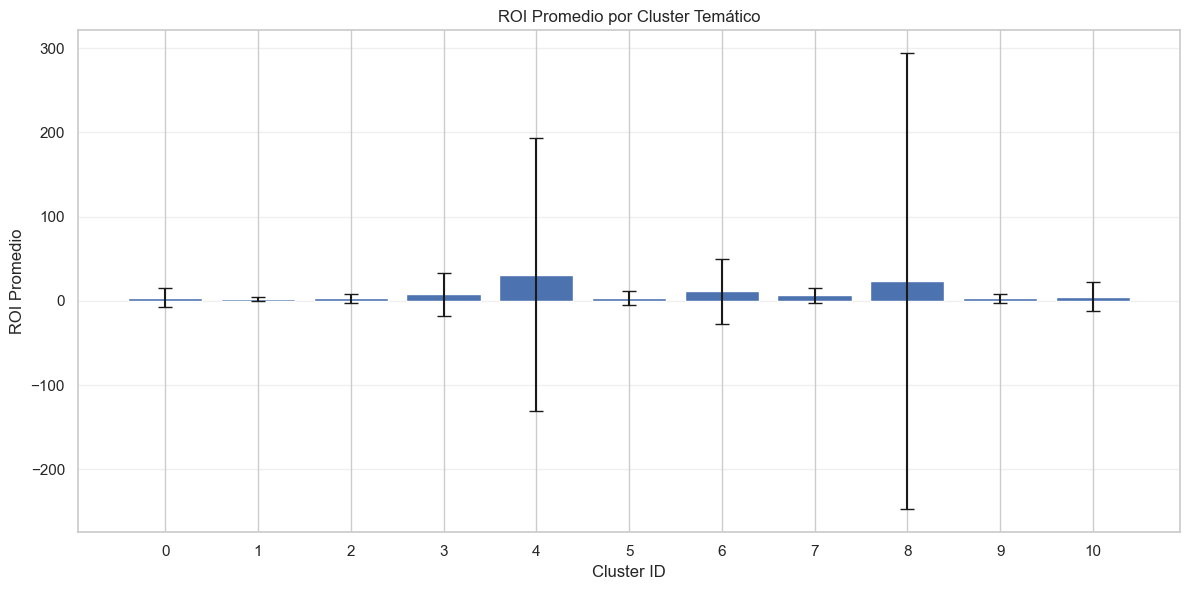


🎬 Películas representativas por cluster (Top 3 por ROI):

Cluster 0 (ROI medio: 3.40):


,title,genres,roi,budget,revenue
402,Jaws,"Adventure, Horror, Thriller",66.236143,7000000,470653000
1338,Jaws 2,"Thriller, Horror",8.394200,20000000,187884000
759,Das Boot,"History, War, Drama",5.071429,14000000,85000000



Cluster 1 (ROI medio: 1.83):


,title,genres,roi,budget,revenue
703,A Clockwork Orange,"Science Fiction, Crime",11.288096,2200000,27033812
16,The Butterfly Effect,"Thriller, Science Fiction",6.446154,13000000,96800000
1942,About Time,"Fantasy, Romance, Drama",6.258371,12000000,87100449



Cluster 2 (ROI medio: 2.84):


,title,genres,roi,budget,revenue
748,The Giant Spider Invasion,"Science Fiction, Horror",49.000000,300000,15000000
1449,Close Encounters of the Third Kind,"Drama, Science Fiction",14.344456,20000000,306889114
1953,Monsters,"Science Fiction, Drama, Thriller",10.279460,500000,5639730



Cluster 3 (ROI medio: 7.73):


,title,genres,roi,budget,revenue
1832,King Kong vs. Godzilla,"Adventure, Science Fiction, Fantasy, Comedy, A...",224.000000,12000,2700000
15,Snow White and the Seven Dwarfs,"Family, Animation, Fantasy",123.242561,1488423,184925486
1858,Fantasia,"Animation, Fantasy, Family",32.513956,2280000,76411819



Cluster 4 (ROI medio: 31.12):


,title,genres,roi,budget,revenue
85,Fist of Fury,"Action, Drama, Thriller",999.000000,100000,100000000
1422,Seven Samurai,"Drama, Action",51.500000,2000000,105000000
797,Lost in the Stars,"Thriller, Crime, Mystery",34.162021,9500000,334039200


In [67]:
if cluster_labels is not None and 'cluster' in df_embeddings_valid.columns:
    # Calcular estadísticas por cluster
    cluster_stats = []
    
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c >= 0])
    
    for cluster_id in unique_clusters:
        cluster_movies = df_embeddings_valid[df_embeddings_valid['cluster'] == cluster_id]
        
        # Géneros más comunes
        all_genres = []
        for genres_str in cluster_movies['genres'].dropna():
            if isinstance(genres_str, str):
                all_genres.extend([g.strip() for g in genres_str.split(',')])
        top_genres = pd.Series(all_genres).value_counts().head(3)
        
        stats = {
            'cluster_id': cluster_id,
            'n_movies': len(cluster_movies),
            'roi_mean': cluster_movies['roi'].mean(),
            'roi_median': cluster_movies['roi'].median(),
            'roi_std': cluster_movies['roi'].std(),
            'budget_mean': cluster_movies['budget'].mean(),
            'revenue_mean': cluster_movies['revenue'].mean(),
            'vote_average_mean': cluster_movies['vote_average'].mean(),
            'top_genres': ', '.join(top_genres.index.tolist())
        }
        cluster_stats.append(stats)
    
    # Agregar estadísticas de ruido si existe
    noise_movies = df_embeddings_valid[df_embeddings_valid['cluster'] == -1]
    if len(noise_movies) > 0:
        stats = {
            'cluster_id': -1,
            'n_movies': len(noise_movies),
            'roi_mean': noise_movies['roi'].mean(),
            'roi_median': noise_movies['roi'].median(),
            'roi_std': noise_movies['roi'].std(),
            'budget_mean': noise_movies['budget'].mean(),
            'revenue_mean': noise_movies['revenue'].mean(),
            'vote_average_mean': noise_movies['vote_average'].mean(),
            'top_genres': 'Ruido'
        }
        cluster_stats.append(stats)
    
    df_cluster_stats = pd.DataFrame(cluster_stats)
    
    print("📊 Estadísticas por Cluster:")
    display(df_cluster_stats.sort_values('roi_mean', ascending=False))
    
    # Análisis adicional de clusters
    print(f"\n🔍 Análisis de clusters:")
    print(f"  Total de películas en clusters: {df_cluster_stats[df_cluster_stats['cluster_id'] >= 0]['n_movies'].sum()}")
    print(f"  Películas en ruido: {df_cluster_stats[df_cluster_stats['cluster_id'] == -1]['n_movies'].values[0] if len(df_cluster_stats[df_cluster_stats['cluster_id'] == -1]) > 0 else 0}")
    print(f"  Cluster con mayor ROI promedio: {df_cluster_stats[df_cluster_stats['cluster_id'] >= 0].nlargest(1, 'roi_mean')['cluster_id'].values[0]}")
    print(f"  Cluster con menor ROI promedio: {df_cluster_stats[df_cluster_stats['cluster_id'] >= 0].nsmallest(1, 'roi_mean')['cluster_id'].values[0]}")
    print(f"  ROI promedio general: {df_embeddings_valid['roi'].mean():.2f}")
    
    # Análisis de variabilidad por cluster
    print(f"\n📊 Variabilidad de ROI por cluster:")
    for cluster_id in unique_clusters[:5]:
        cluster_data = df_cluster_stats[df_cluster_stats['cluster_id'] == cluster_id]
        if len(cluster_data) > 0:
            roi_std = cluster_data['roi_std'].values[0]
            roi_mean = cluster_data['roi_mean'].values[0]
            cv_roi = roi_std / roi_mean if roi_mean != 0 else 0
            print(f"  Cluster {cluster_id}: CV = {cv_roi:.2f} (std/mean), {'alta' if cv_roi > 1 else 'moderada' if cv_roi > 0.5 else 'baja'} variabilidad")
    
    # Visualizar ROI por cluster
    plt.figure(figsize=(12, 6))
    clusters_to_plot = [c for c in unique_clusters if c >= 0]
    roi_means = [df_cluster_stats[df_cluster_stats['cluster_id'] == c]['roi_mean'].values[0] 
                 for c in clusters_to_plot]
    roi_stds = [df_cluster_stats[df_cluster_stats['cluster_id'] == c]['roi_std'].values[0] 
                for c in clusters_to_plot]
    
    plt.bar(range(len(clusters_to_plot)), roi_means, yerr=roi_stds, capsize=5)
    plt.xlabel('Cluster ID')
    plt.ylabel('ROI Promedio')
    plt.title('ROI Promedio por Cluster Temático')
    plt.xticks(range(len(clusters_to_plot)), clusters_to_plot)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Mostrar películas representativas de algunos clusters
    print("\n🎬 Películas representativas por cluster (Top 3 por ROI):")
    for cluster_id in unique_clusters[:5]:  # Primeros 5 clusters
        cluster_movies = df_embeddings_valid[df_embeddings_valid['cluster'] == cluster_id]
        top_movies = cluster_movies.nlargest(3, 'roi')[['title', 'genres', 'roi', 'budget', 'revenue']]
        print(f"\nCluster {cluster_id} (ROI medio: {df_cluster_stats[df_cluster_stats['cluster_id'] == cluster_id]['roi_mean'].values[0]:.2f}):")
        display(top_movies)
else:
    print("⚠️ No hay clusters disponibles para análisis")


### 💾 Estado de persistencia de modelos

In [68]:
# Guardar modelos entrenados
import joblib
import os

# Crear directorio para modelos si no existe
os.makedirs('saved_models', exist_ok=True)

# Guardar modelo de ROI
roi_path = 'saved_models/modelo_roi.joblib'
joblib.dump({
    'model': model_roi,
    'metrics': metrics_roi,
    'feature_columns': feature_cols_roi,
    'feature_importance': feature_importance_roi
}, roi_path)
print(f'✅ Modelo de ROI guardado en {roi_path}')

# Guardar modelo de Revenue
rev_path = 'saved_models/modelo_revenue.joblib'
joblib.dump({
    'model': model_rev,
    'metrics': metrics_rev,
    'feature_columns': feature_cols_rev,
    'feature_importance': feature_importance_rev
}, rev_path)
print(f'✅ Modelo de Revenue guardado en {rev_path}')

# Guardar modelo de Rentabilidad
prof_path = 'saved_models/modelo_rentabilidad.joblib'
joblib.dump({
    'model': model_prof,
    'metrics': metrics_prof,
    'feature_columns': feature_cols_prof,
    'feature_importance': feature_importance_prof,
    'profitability_threshold': PROFITABILITY_THRESHOLD,
    'confusion_matrix': cm
}, prof_path)
print(f'✅ Modelo de Rentabilidad guardado en {prof_path} (threshold: {PROFITABILITY_THRESHOLD})')

# Guardar feature engineer
fe_path = 'saved_models/feature_engineer.joblib'
joblib.dump(feature_engineer, fe_path)
print(f'✅ Feature Engineer guardado en {fe_path}')

print(f"\n📦 Todos los modelos guardados en el directorio 'saved_models/'")


✅ Modelo de ROI guardado en saved_models/modelo_roi.joblib
✅ Modelo de Revenue guardado en saved_models/modelo_revenue.joblib
✅ Modelo de Rentabilidad guardado en saved_models/modelo_rentabilidad.joblib (threshold: 2.0)
✅ Feature Engineer guardado en saved_models/feature_engineer.joblib

📦 Todos los modelos guardados en el directorio 'saved_models/'


## 🛫 Cierre de la entrega: Reflexiones finales

En esta celda se hace un cierre de la etapa con observaciones sobre el resultado de los modelos, ventajas/desventajas, y posibles mejoras futuras.

### Resumen de resultados obtenidos

**Modelo de ROI:**
- Rendimiento limitado (R² test: 0.1030, R² CV: 0.1270)
- El truncamiento mejoró la estabilidad, pero el R² sigue siendo bajo
- Requiere mejoras significativas en características y transformaciones

**Modelo de Revenue:**
- Rendimiento moderado-alto y estable (R² test: 0.5431)
- Excelente generalización (ratios test/train ~1.0)
- CV estable (0.5163 ± 0.0489) indica buena generalización
- Errores absolutos grandes pero proporcionales

**Modelo de Rentabilidad:**
- Rendimiento moderado (Accuracy: 0.6625, ROC AUC: 0.7077)
- Buena especificidad (79.51%) pero recall limitado (48.74%)
- Útil para identificar películas no rentables, pero puede perder oportunidades

### Conclusiones

Los modelos implementados proporcionan una base sólida para la predicción del éxito comercial de películas. Aunque hay margen de mejora, los resultados demuestran que:

1. **Las características disponibles son predictivas**: Los modelos capturan patrones significativos, especialmente para Revenue y Rentabilidad
2. **Random Forest es apropiado**: Maneja bien la mezcla de variables categóricas y numéricas, aunque el modelo de ROI requiere mejoras
3. **Los embeddings permiten clustering temático**: Identifican 9 grupos de películas con contenido similar, con variabilidad en ROI entre clusters
4. **El enfoque es escalable**: La arquitectura permite agregar más datos y características

### Próximos pasos sugeridos

1. **Mejora del modelo de ROI**: Transformaciones logarítmicas, detección y tratamiento de outliers
2. **Optimización de threshold**: Análisis de diferentes thresholds de rentabilidad según objetivos de negocio
3. **Ensemble methods**: Combinar modelos para mejorar rendimiento general
4. **Validación temporal**: Usar splits temporales para validación más realista

La implementación actual sirve como punto de partida para un sistema de recomendación y análisis más sofisticado en la industria cinematográfica.
